In [1]:
print('hola!')

hola!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
import warnings
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from math import sqrt
import tensorflow as tf
import tensorflow_probability as tfp
import keras
from keras.utils.np_utils import to_categorical
from keras.datasets import mnist
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import datetime
import pickle
tfk = tf.keras
tf.keras.backend.set_floatx("float64")
tfd = tfp.distributions
# Load the TensorBoard notebook extension
%load_ext tensorboard

C:\Users\loren\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
os.chdir('C:\\Users\\loren\\PycharmProjects\\Bayes')

In [4]:
df_weather = pd.read_csv("weather_features.csv", parse_dates=['dt_iso'])
df_energy = pd.read_csv("energy_dataset.csv", parse_dates=['time'])

In [5]:
df_energy['generation coal'] = df_energy['generation fossil hard coal'] + df_energy[
    'generation fossil brown coal/lignite']
df_energy['generation hydro'] = df_energy['generation hydro water reservoir'] + df_energy[
    'generation hydro pumped storage consumption'] + df_energy['generation hydro run-of-river and poundage']
df_energy['generation wind'] = df_energy['generation wind onshore'] + df_energy['generation wind offshore']

In [6]:
# Drop unusable columns

df_energy = df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale',
                            'generation fossil peat', 'generation geothermal',
                            'generation hydro pumped storage aggregated', 'generation marine',
                            'generation wind offshore','generation wind onshore', 'forecast wind offshore eday ahead',
                            'generation hydro water reservoir','generation hydro pumped storage consumption',
                            'generation hydro run-of-river and poundage', 'generation fossil hard coal',
                            'generation fossil brown coal/lignite', 'forecast solar day ahead', 'forecast wind onshore day ahead',
                            'total load forecast', 'price day ahead'],
                            axis=1)

In [7]:
df_energy['generation non-renewable'] = df_energy['generation fossil gas'] + df_energy['generation fossil oil'] + df_energy['generation nuclear'] + df_energy['generation other'] + \
                                        df_energy['generation coal'] + df_energy['generation waste']
df_energy['generation renewable'] = df_energy['generation solar'] + df_energy['generation biomass'] + df_energy['generation hydro'] + df_energy['generation other renewable'] + \
                                    df_energy['generation wind']

In [8]:
df_energy.describe().round(2)

,generation biomass,generation fossil gas,generation fossil oil,generation nuclear,generation other,generation other renewable,generation solar,generation waste,total load actual,price actual,generation coal,generation hydro,generation wind,generation non-renewable,generation renewable
count,35045.00,35046.00,35045.00,35047.00,35046.00,35046.00,35046.00,35045.00,35028.00,35064.00,35046.00,35044.0,35046.00,35044.00,35043.00
mean,383.51,5622.74,298.32,6263.91,60.23,85.64,1432.67,269.45,28696.94,57.88,4704.12,4052.9,5464.48,17218.86,11419.55
std,85.35,2201.83,52.52,839.67,20.24,14.08,1680.12,50.20,4574.99,14.20,2245.64,2114.0,3213.69,3982.96,4254.98
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18041.00,9.33,0.00,0.0,0.00,6363.00,0.00
25%,333.00,4126.00,263.00,5760.00,53.00,73.00,71.00,240.00,24807.75,49.35,2678.00,2393.0,2933.00,14031.75,8266.00
50%,367.00,4969.00,300.00,6566.00,57.00,88.00,616.00,279.00,28901.00,58.02,4983.00,3589.0,4849.00,17005.00,10896.00
75%,433.00,6429.00,330.00,7025.00,80.00,97.00,2578.00,310.00,32192.00,68.01,6503.00,5314.0,7398.00,19973.00,14023.00
max,592.00,20034.00,449.00,7117.00,106.00,119.00,5792.00,357.00,41015.00,116.80,9320.00,11613.0,17436.00,34498.00,27691.00


In [9]:
df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)
df_energy = df_energy.set_index('time')

In [10]:
# Find NaNs and duplicates in df_energy

print('There are {} missing values or NaNs in df_energy.'
      .format(df_energy.isnull().values.sum()))

temp_energy = df_energy.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_energy based on all columns.'
      .format(temp_energy))

There are 279 missing values or NaNs in df_energy.
There are 0 duplicate rows in df_energy based on all columns.


In [11]:
# Find the number of NaNs in each column

df_energy.isnull().sum(axis=0)

generation biomass            19
generation fossil gas         18
generation fossil oil         19
generation nuclear            17
generation other              18
generation other renewable    18
generation solar              18
generation waste              19
total load actual             36
price actual                   0
generation coal               18
generation hydro              20
generation wind               18
generation non-renewable      20
generation renewable          21
dtype: int64

In [12]:
# Display the rows with null values

df_energy[df_energy.isnull().any(axis=1)].tail()

,generation biomass,generation fossil gas,generation fossil oil,generation nuclear,generation other,generation other renewable,generation solar,generation waste,total load actual,price actual,generation coal,generation hydro,generation wind,generation non-renewable,generation renewable
time,,,,,,,,,,,,,,,
2016-11-23 03:00:00+00:00,NaN,4838.0,269.0,5040.0,60.0,85.0,15.0,227.0,23112.0,49.11,5447.0,2643.0,4598.0,15881.0,NaN
2017-11-14 11:00:00+00:00,0.0,10064.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,66.17,0.0,0.0,0.0,10064.0,0.0
2017-11-14 18:00:00+00:00,0.0,12336.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,75.45,0.0,0.0,0.0,12336.0,0.0
2018-06-11 16:00:00+00:00,331.0,7538.0,300.0,5856.0,52.0,96.0,170.0,269.0,NaN,64.93,5866.0,5393.0,9165.0,19881.0,15155.0
2018-07-11 07:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.79,NaN,NaN,NaN,NaN,NaN


In [13]:
# Fill null values using interpolation

df_energy.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [14]:
# Display the number of non-zero values in each column

print('Non-zero values in each column:\n', df_energy.astype(bool).sum(axis=0), sep='\n')

Non-zero values in each column:

generation biomass            35060
generation fossil gas         35063
generation fossil oil         35061
generation nuclear            35061
generation other              35060
generation other renewable    35061
generation solar              35061
generation waste              35061
total load actual             35064
price actual                  35064
generation coal               35061
generation hydro              35061
generation wind               35061
generation non-renewable      35064
generation renewable          35061
dtype: int64


In [15]:
df_weather.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear


In [16]:
df_weather.describe().round(2)

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00
mean,289.62,288.33,291.09,1069.26,68.42,2.47,166.59,0.08,0.00,0.00,25.07,759.83
std,8.03,7.96,8.61,5969.63,21.90,2.10,116.61,0.40,0.01,0.22,30.77,108.73
min,262.24,262.24,262.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,200.00
25%,283.67,282.48,284.65,1013.00,53.00,1.00,55.00,0.00,0.00,0.00,0.00,800.00
50%,289.15,288.15,290.15,1018.00,72.00,2.00,177.00,0.00,0.00,0.00,20.00,800.00
75%,295.15,293.73,297.15,1022.00,87.00,4.00,270.00,0.00,0.00,0.00,40.00,801.00
max,315.60,315.15,321.15,1008371.00,100.00,133.00,360.00,12.00,2.32,21.50,100.00,804.00


In [17]:
# Print the type of each variable in df_weather

df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [18]:
def df_convert_dtypes(df, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df

In [19]:
df_weather = df_convert_dtypes(df_weather, np.int64, np.float64)

In [20]:
df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)
df_weather = df_weather.drop(['dt_iso'], axis=1)
df_weather = df_weather.set_index('time')

In [21]:
# Display average weather features grouped by each city

mean_weather_by_city = df_weather.groupby('city_name').mean()
mean_weather_by_city

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
city_name,,,,,,,,,,,,
Barcelona,289.848248,288.594704,291.021987,1284.010486,73.994221,2.786588,187.188043,0.117079,0.000327,0.000000,23.229648,760.917465
Bilbao,286.378489,284.916661,288.036687,1017.567439,79.089455,1.957470,159.883536,0.123493,0.001034,0.023455,43.960697,723.943228
Madrid,288.061071,286.824877,289.155600,1011.838448,59.776932,2.441696,173.293159,0.055083,0.000129,0.000029,22.397028,762.260264
Seville,293.105431,291.184103,295.962431,1018.504711,64.140732,2.483787,151.757179,0.045392,0.000180,0.000000,14.748770,771.409849
Valencia,290.780780,290.222277,291.355025,1015.973794,65.145113,2.692815,160.753820,0.035924,0.000226,0.000154,20.820999,781.228283


In [22]:
# Find NaNs and duplicates in df_weather

print('There are {} missing values or NaNs in df_weather.'
      .format(df_weather.isnull().values.sum()))

temp_weather = df_weather.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_weather based on all columns.'
      .format(temp_weather))

There are 0 missing values or NaNs in df_weather.
There are 9935 duplicate rows in df_weather based on all columns.


In [23]:
# Display the number of rows in each dataframe

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

cities = df_weather['city_name'].unique()
grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]),
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35145 observations in df_weather about city: Valencia.
There are 36267 observations in df_weather about city: Madrid.
There are 35951 observations in df_weather about city: Bilbao.
There are 35476 observations in df_weather about city:  Barcelona.
There are 35557 observations in df_weather about city: Seville.


In [24]:
df_weather = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'],
                                                      keep='first').set_index('time')

In [25]:
# Display the number of rows in each dataframe again

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]),
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35064 observations in df_weather about city: Valencia.
There are 35064 observations in df_weather about city: Madrid.
There are 35064 observations in df_weather about city: Bilbao.
There are 35064 observations in df_weather about city:  Barcelona.
There are 35064 observations in df_weather about city: Seville.


In [26]:
# Drop columns with qualitative weather information
df_weather = df_weather.drop(['weather_main', 'weather_id',
                              'weather_description'],
                             axis=1)

In [27]:
df_weather.head()

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all
time,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0
2015-01-01 00:00:00+00:00,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0
2015-01-01 01:00:00+00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0
2015-01-01 02:00:00+00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0
2015-01-01 03:00:00+00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0


In [28]:
# Display the number of duplicates in df_weather

temp_weather = df_weather.reset_index().duplicated(subset=['time', 'city_name'],
                                                   keep='first').sum()
print('There are {} duplicate rows in df_weather ' \
      'based on all columns except "time" and "city_name".'.format(temp_weather))

There are 0 duplicate rows in df_weather based on all columns except "time" and "city_name".


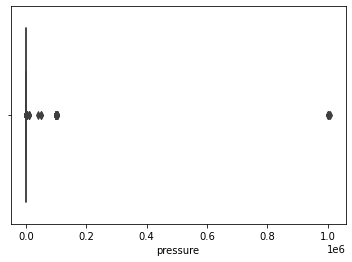

In [29]:
# Check for outliers in 'pressure' column

sns.boxplot(x=df_weather['pressure'])
plt.show()

In [30]:
# Replace outliers in 'pressure' with NaNs

df_weather.loc[df_weather.pressure > 1051, 'pressure'] = np.nan
df_weather.loc[df_weather.pressure < 931, 'pressure'] = np.nan

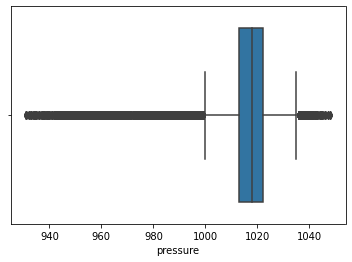

In [31]:
# Check for outliers in 'pressure' column again

sns.boxplot(x=df_weather['pressure'])
plt.show()

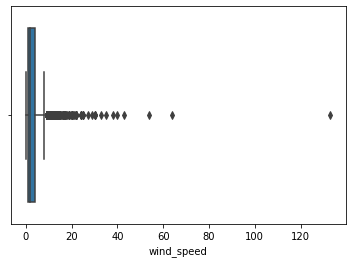

In [32]:
# Check for outliers in 'wind_speed' column

sns.boxplot(x=df_weather['wind_speed'])
plt.show()

In [33]:
# Replace outliers in 'wind_speed' with NaNs

df_weather.loc[df_weather.wind_speed > 50, 'wind_speed'] = np.nan

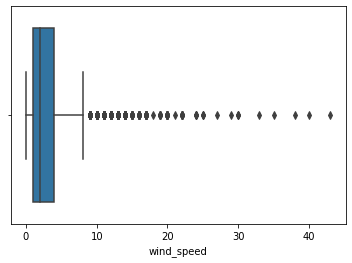

In [34]:
# Check for outliers in 'wind_speed' column again

sns.boxplot(x=df_weather['wind_speed'])
plt.show()

In [35]:
# Fill null values using interpolation

df_weather.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [36]:
# Split the df_weather into 5 dataframes (one for each city)

df_1, df_2, df_3, df_4, df_5 = [x for _, x in df_weather.groupby('city_name')]
dfs = [df_1, df_2, df_3, df_4, df_5]

In [37]:
cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

In [38]:
# Merge all dataframes into the final dataframe

df_final = df_energy

for df in dfs:
    city = df['city_name'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df = df.add_suffix('_{}'.format(city_str))
    df_final = df_final.merge(df, on=['time'], how='outer')
    df_final = df_final.drop('city_name_{}'.format(city_str), axis=1)

df_final.columns

Index(['generation biomass', 'generation fossil gas', 'generation fossil oil',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'total load actual',
       'price actual', 'generation coal', 'generation hydro',
       'generation wind', 'generation non-renewable', 'generation renewable',
       'temp_Barcelona', 'temp_min_Barcelona', 'temp_max_Barcelona',
       'pressure_Barcelona', 'humidity_Barcelona', 'wind_speed_Barcelona',
       'wind_deg_Barcelona', 'rain_1h_Barcelona', 'rain_3h_Barcelona',
       'snow_3h_Barcelona', 'clouds_all_Barcelona', 'temp_Bilbao',
       'temp_min_Bilbao', 'temp_max_Bilbao', 'pressure_Bilbao',
       'humidity_Bilbao', 'wind_speed_Bilbao', 'wind_deg_Bilbao',
       'rain_1h_Bilbao', 'rain_3h_Bilbao', 'snow_3h_Bilbao',
       'clouds_all_Bilbao', 'temp_Madrid', 'temp_min_Madrid',
       'temp_max_Madrid', 'pressure_Madrid', 'humidity_Madrid',
       'wind_speed_Madrid', 'wind_d

In [39]:
df_final.head()

,generation biomass,generation fossil gas,generation fossil oil,generation nuclear,generation other,generation other renewable,generation solar,generation waste,total load actual,price actual,...,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,rain_3h_Valencia,snow_3h_Valencia,clouds_all_Valencia
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,4844.0,162.0,7096.0,43.0,73.0,49.0,196.0,25385.0,65.41,...,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0
2015-01-01 00:00:00+00:00,449.0,5196.0,158.0,7096.0,43.0,71.0,50.0,195.0,24382.0,64.92,...,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0
2015-01-01 01:00:00+00:00,448.0,4857.0,157.0,7099.0,43.0,73.0,50.0,196.0,22734.0,64.48,...,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0
2015-01-01 02:00:00+00:00,438.0,4314.0,160.0,7098.0,43.0,75.0,50.0,191.0,21286.0,59.32,...,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0
2015-01-01 03:00:00+00:00,428.0,4130.0,156.0,7097.0,43.0,74.0,42.0,189.0,20264.0,56.04,...,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0


In [40]:
# Display the number of NaNs and duplicates in the final dataframe

print('There are {} missing values or NaNs in df_final.'
      .format(df_final.isnull().values.sum()))

temp_final = df_final.duplicated(keep='first').sum()

print('\nThere are {} duplicate rows in df_energy based on all columns.'
      .format(temp_final))

There are 0 missing values or NaNs in df_final.

There are 0 duplicate rows in df_energy based on all columns.


In [41]:
# Generate 'hour', 'weekday' and 'month' features

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    weekday = position.weekday()
    month = position.month
    df_final.loc[position, 'hour'] = hour
    df_final.loc[position, 'weekday'] = weekday
    df_final.loc[position, 'month'] = month

In [42]:
# Generate 'business hour' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    if 8 <= hour <= 18:
        df_final.loc[position, 'business hour'] = 1
    else:
        df_final.loc[position, 'business hour'] = 0

In [43]:
# Generate 'weekend' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    weekday = position.weekday()
    if (weekday == 7):
        df_final.loc[position, 'weekday'] = 2
    elif (weekday == 6):
        df_final.loc[position, 'weekday'] = 1
    else:
        df_final.loc[position, 'weekday'] = 0

In [44]:
# Calculate the weight of every city

total_pop = 6155116 + 5179243 + 1645342 + 1305342 + 987000

weight_Madrid = 6155116 / total_pop
weight_Barcelona = 5179243 / total_pop
weight_Valencia = 1645342 / total_pop
weight_Seville = 1305342 / total_pop
weight_Bilbao = 987000 / total_pop

In [45]:
cities_weights = {'Madrid': weight_Madrid,
                  'Barcelona': weight_Barcelona,
                  'Valencia': weight_Valencia,
                  'Seville': weight_Seville,
                  'Bilbao': weight_Bilbao}

In [46]:
features_list = [c for c in df_final.columns if c.startswith('generation')]
features_list

['generation biomass',
 'generation fossil gas',
 'generation fossil oil',
 'generation nuclear',
 'generation other',
 'generation other renewable',
 'generation solar',
 'generation waste',
 'generation coal',
 'generation hydro',
 'generation wind',
 'generation non-renewable',
 'generation renewable']

In [47]:
for city, weight in cities_weights.items():
    for feature in features_list:
        df_final[feature + '_' + city] = df_final[feature]*weight

In [48]:
df_final['temp_min'] = (df_final['temp_min_Madrid'] + df_final['temp_min_Bilbao'] + df_final['temp_min_Barcelona'] + df_final['temp_min_Seville'] + df_final['temp_min_Valencia'])/5
df_final['temp'] = (df_final['temp_Madrid'] + df_final['temp_Bilbao'] + df_final['temp_Barcelona'] + df_final['temp_Seville'] + df_final['temp_Valencia'])/5
df_final['temp_max'] = (df_final['temp_max_Madrid'] + df_final['temp_max_Bilbao'] + df_final['temp_max_Barcelona'] + df_final['temp_max_Seville'] + df_final['temp_max_Valencia'])/5
df_final['pressure'] = (df_final['pressure_Madrid'] + df_final['pressure_Bilbao'] + df_final['pressure_Barcelona'] + df_final['pressure_Seville'] + df_final['pressure_Valencia'])/5
df_final['humidity'] = (df_final['humidity_Madrid'] + df_final['humidity_Bilbao'] + df_final['humidity_Barcelona'] + df_final['humidity_Seville'] + df_final['humidity_Valencia'])/5
df_final['wind_speed'] = (df_final['wind_speed_Madrid'] + df_final['wind_speed_Bilbao'] + df_final['wind_speed_Barcelona'] + df_final['wind_speed_Seville'] + df_final['wind_speed_Valencia'])/5
df_final['rain_1h'] = (df_final['rain_1h_Madrid'] + df_final['rain_1h_Bilbao'] + df_final['rain_1h_Barcelona'] + df_final['rain_1h_Seville'] + df_final['rain_1h_Valencia'])/5
df_final['snow_3h'] = (df_final['snow_3h_Madrid'] + df_final['snow_3h_Bilbao'] + df_final['snow_3h_Barcelona'] + df_final['snow_3h_Seville'] + df_final['snow_3h_Valencia'])/5
df_final['clouds_all'] = (df_final['clouds_all_Madrid'] + df_final['clouds_all_Bilbao'] + df_final['clouds_all_Barcelona'] + df_final['clouds_all_Seville'] + df_final['clouds_all_Valencia'])/5

In [49]:
df_final.columns

Index(['generation biomass', 'generation fossil gas', 'generation fossil oil',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'total load actual',
       'price actual',
       ...
       'generation renewable_Bilbao', 'temp_min', 'temp', 'temp_max',
       'pressure', 'humidity', 'wind_speed', 'rain_1h', 'snow_3h',
       'clouds_all'],
      dtype='object', length=148)

In [50]:
df_final.head().round(2)

,generation biomass,generation fossil gas,generation fossil oil,generation nuclear,generation other,generation other renewable,generation solar,generation waste,total load actual,price actual,...,generation renewable_Bilbao,temp_min,temp,temp_max,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,4844.0,162.0,7096.0,43.0,73.0,49.0,196.0,25385.0,65.41,...,695.40,272.49,272.49,272.49,1016.4,82.4,2.0,0.0,0.0,0.0
2015-01-01 00:00:00+00:00,449.0,5196.0,158.0,7096.0,43.0,71.0,50.0,195.0,24382.0,64.92,...,649.32,272.51,272.51,272.51,1016.2,82.4,2.0,0.0,0.0,0.0
2015-01-01 01:00:00+00:00,448.0,4857.0,157.0,7099.0,43.0,73.0,50.0,196.0,22734.0,64.48,...,616.55,272.10,272.10,272.10,1016.8,82.0,2.4,0.0,0.0,0.0
2015-01-01 02:00:00+00:00,438.0,4314.0,160.0,7098.0,43.0,75.0,50.0,191.0,21286.0,59.32,...,583.72,272.09,272.09,272.09,1016.6,82.0,2.4,0.0,0.0,0.0
2015-01-01 03:00:00+00:00,428.0,4130.0,156.0,7097.0,43.0,74.0,42.0,189.0,20264.0,56.04,...,580.23,272.15,272.15,272.15,1016.6,82.0,2.4,0.0,0.0,0.0


In [51]:
# Define a function to plot different types of time-series

def plot_series(df=None, column=None, series=pd.Series([]),
                label=None, ylabel=None, title=None, start=0, end=None):
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax


C:\Users\loren\AppData\Local\Temp\ipykernel_36928\1307930110.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def plot_series(df=None, column=None, series=pd.Series([]),


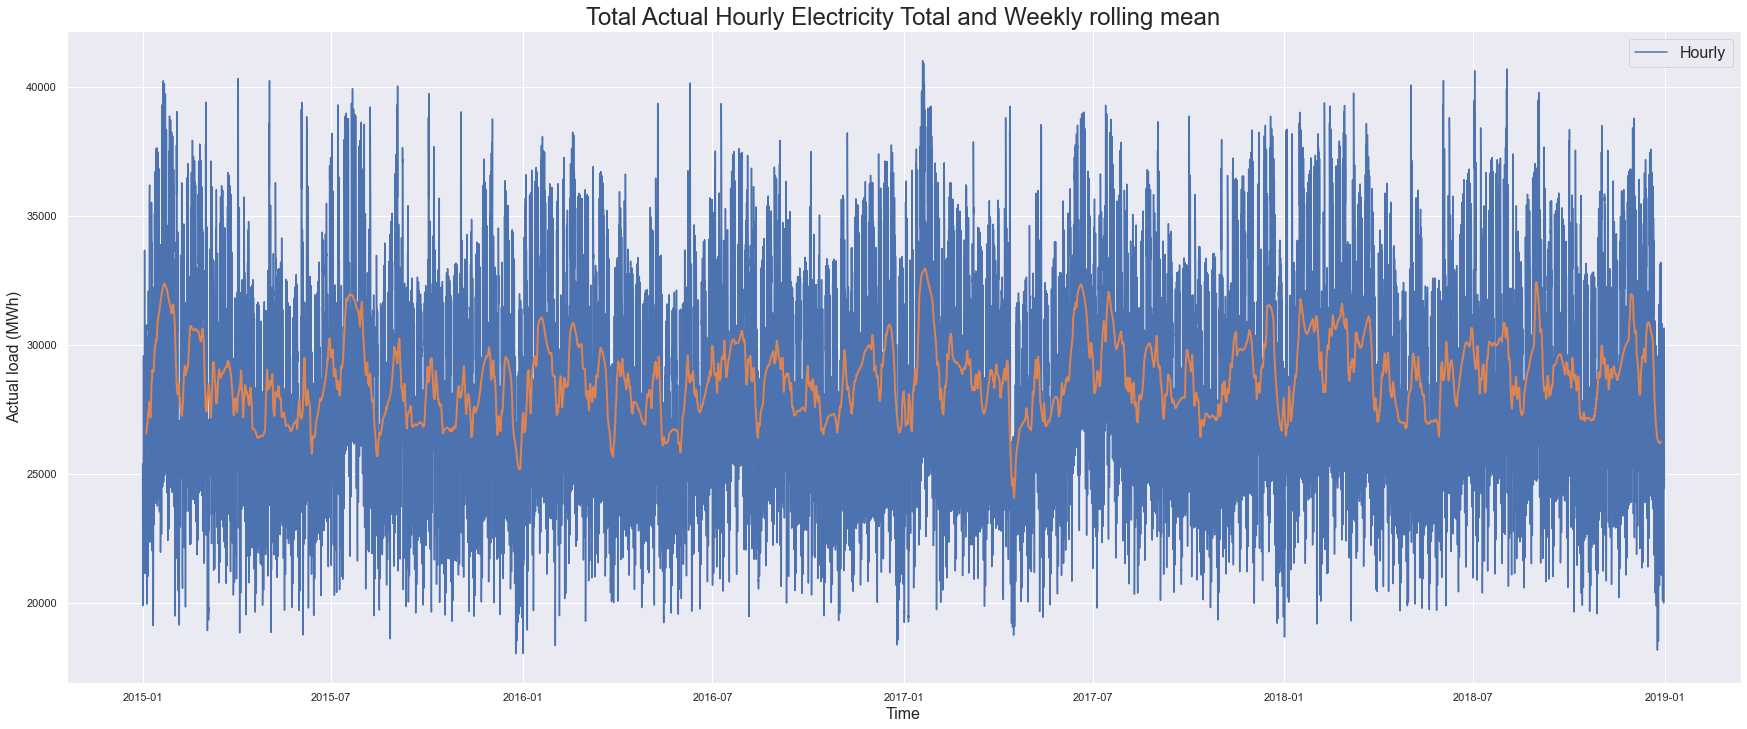

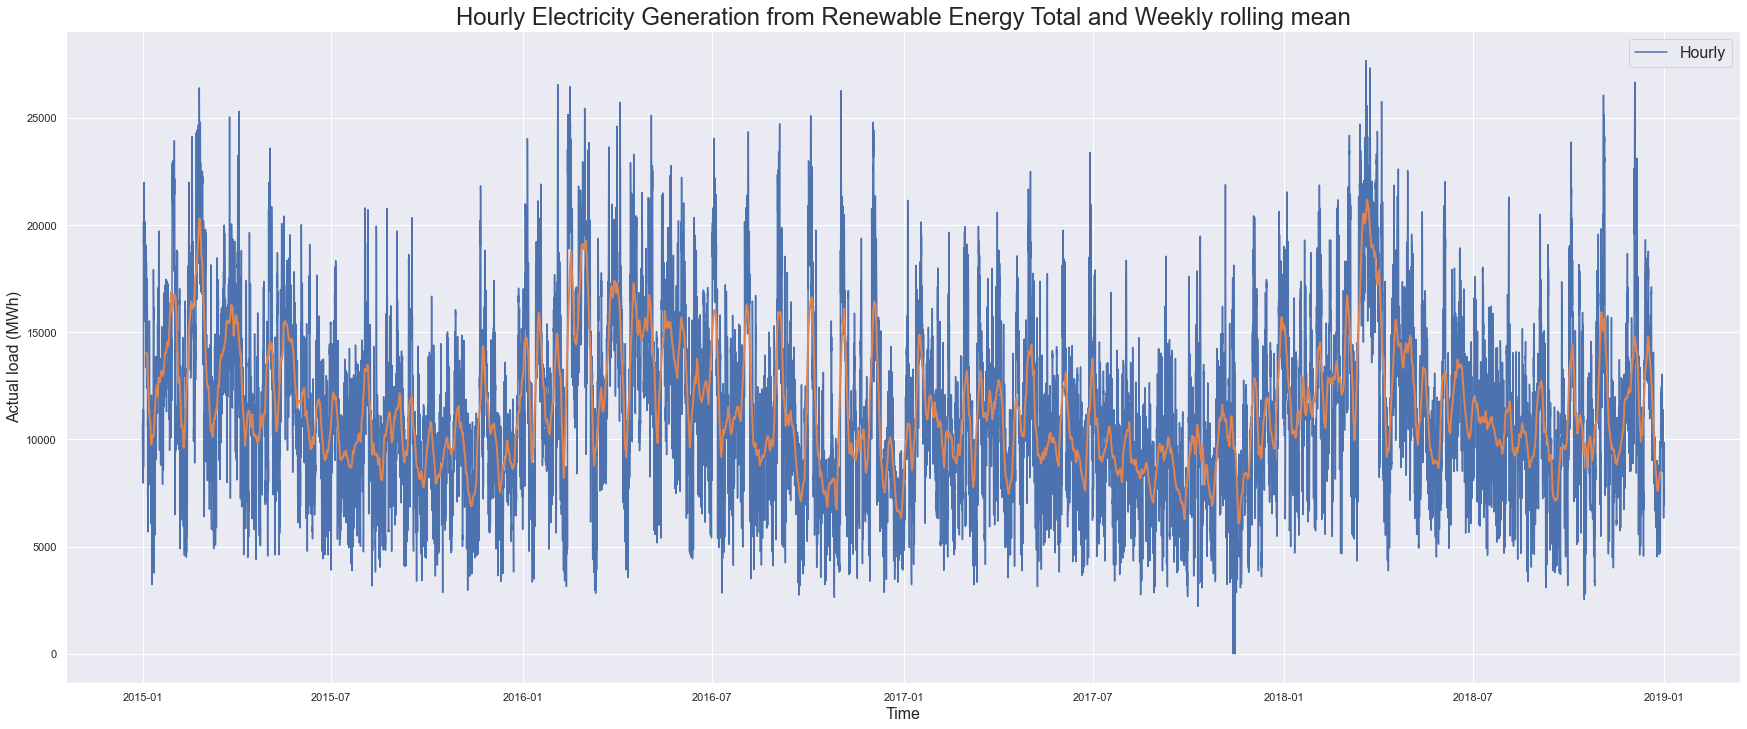

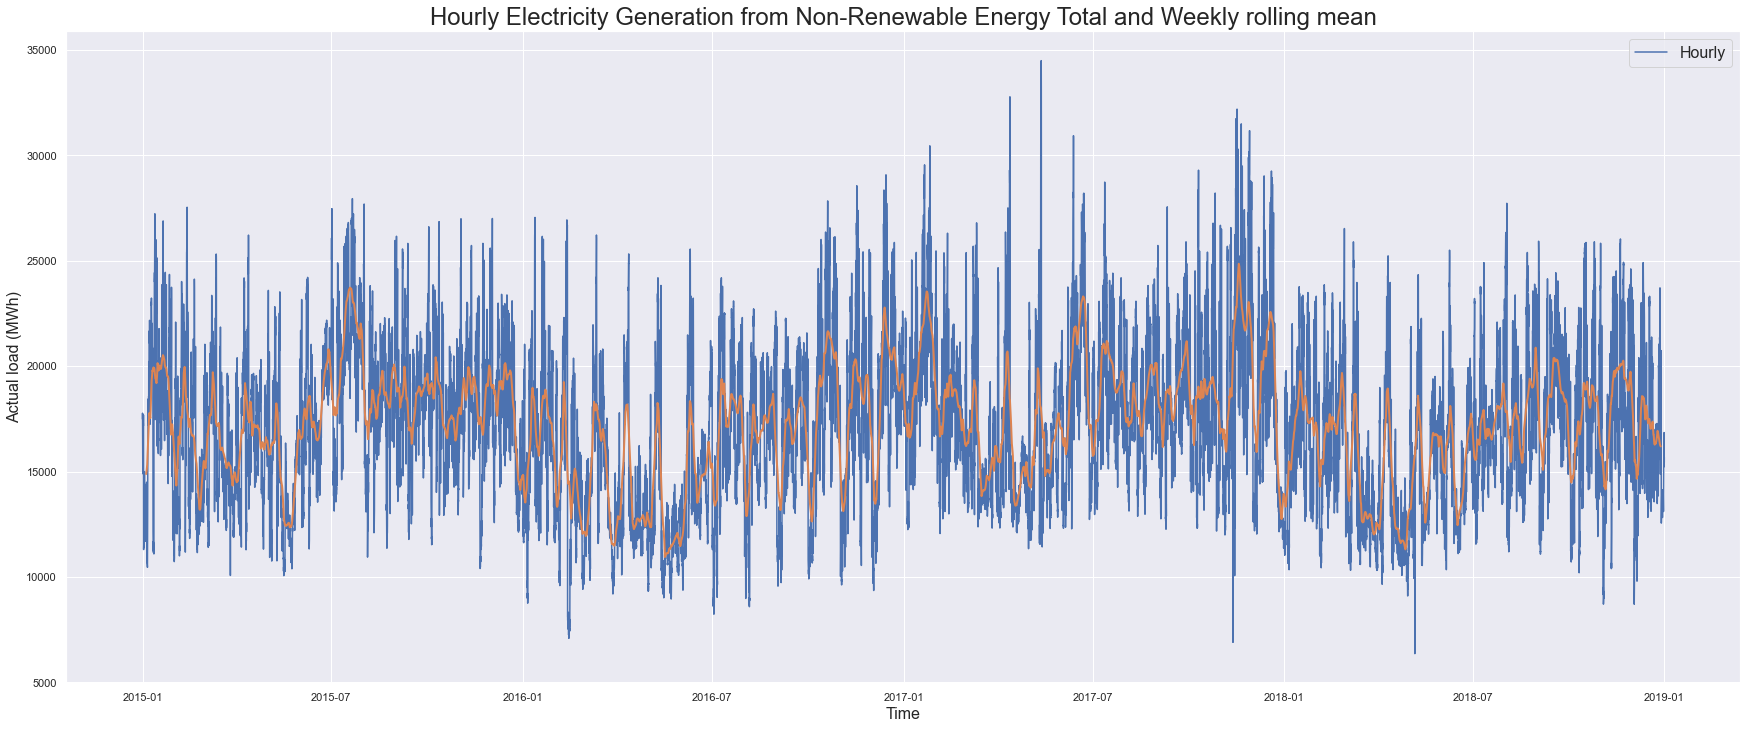

In [52]:

# Plot the hourly actual electricity total load, along with the weekly rolling mean

rolling1 = df_final['total load actual'].rolling(24 * 7, center=True).mean()
rolling2 = df_final['generation renewable'].rolling(24 * 7, center=True).mean()
rolling3 = df_final['generation non-renewable'].rolling(24 * 7, center=True).mean()
ax1 = plot_series(df_final, 'total load actual', label='Hourly', ylabel='Actual load (MWh)',
                  title='Total Actual Hourly Electricity Total and Weekly rolling mean')
ax2 = plot_series(df_final, 'generation renewable', label='Hourly', ylabel='Actual load (MWh)',
                  title='Hourly Electricity Generation from Renewable Energy Total and Weekly rolling mean')
ax3 = plot_series(df_final, 'generation non-renewable', label='Hourly', ylabel='Actual load (MWh)',
                  title='Hourly Electricity Generation from Non-Renewable Energy Total and Weekly rolling mean')
ax1.plot(rolling1, linestyle='-', linewidth=2, label='Weekly rolling mean')
ax2.plot(rolling2, linestyle='-', linewidth=2, label='Weekly rolling mean')
ax3.plot(rolling3, linestyle='-', linewidth=2, label='Weekly rolling mean')

plt.show()

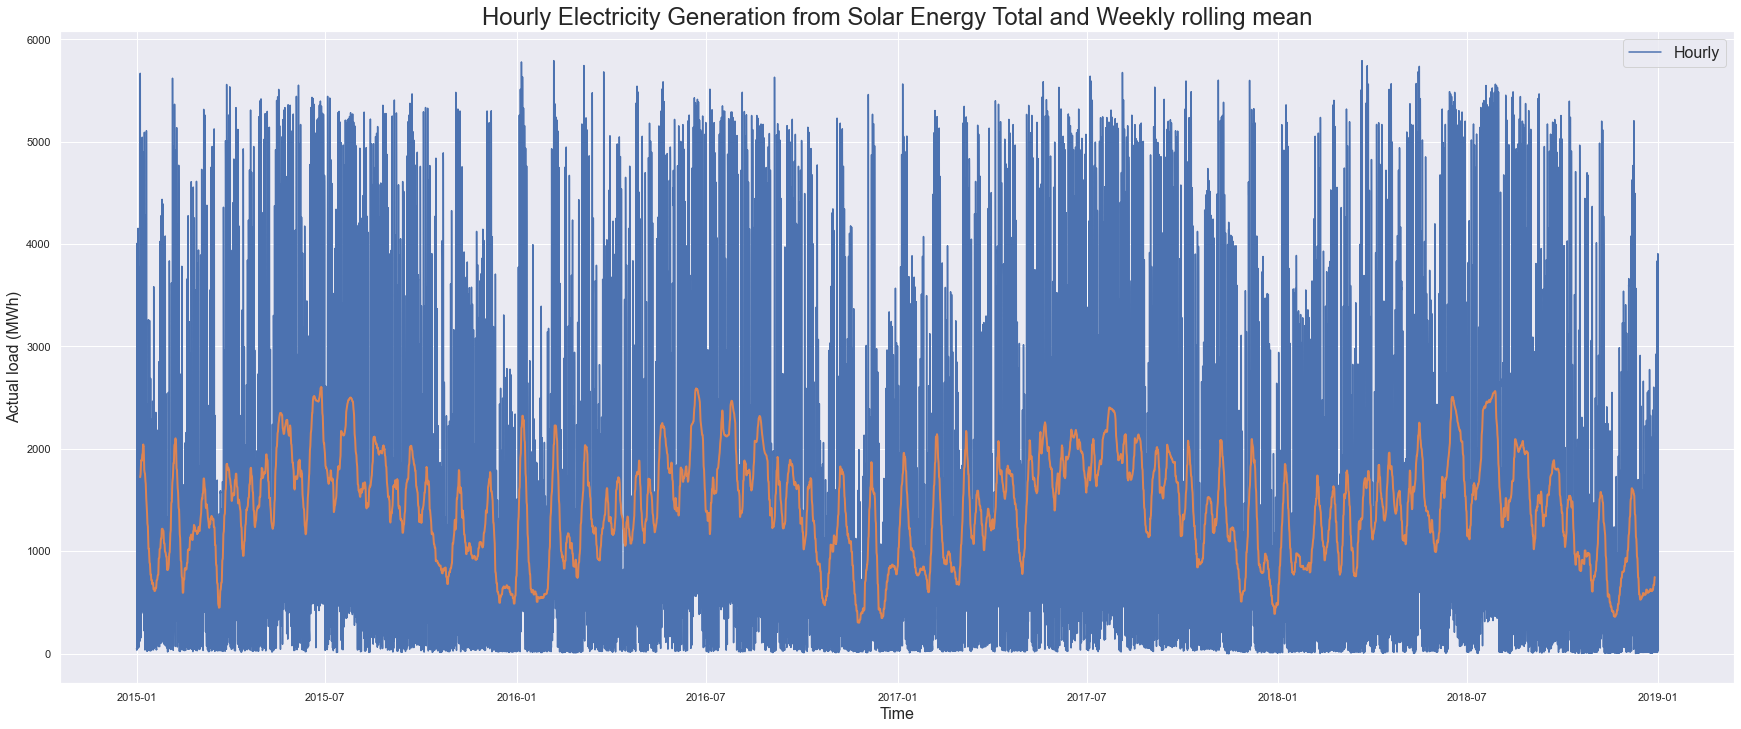

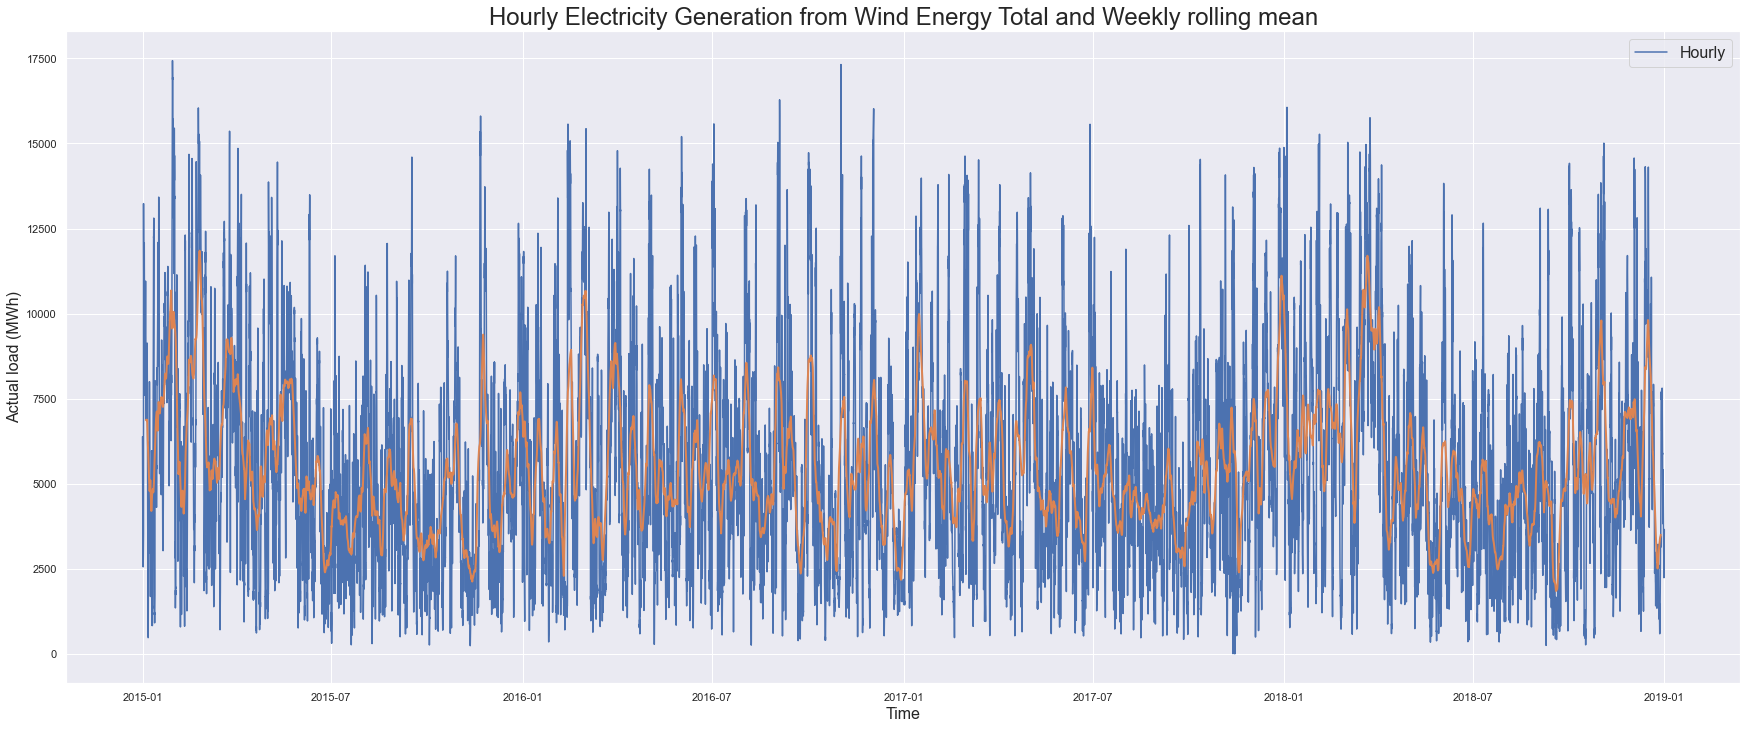

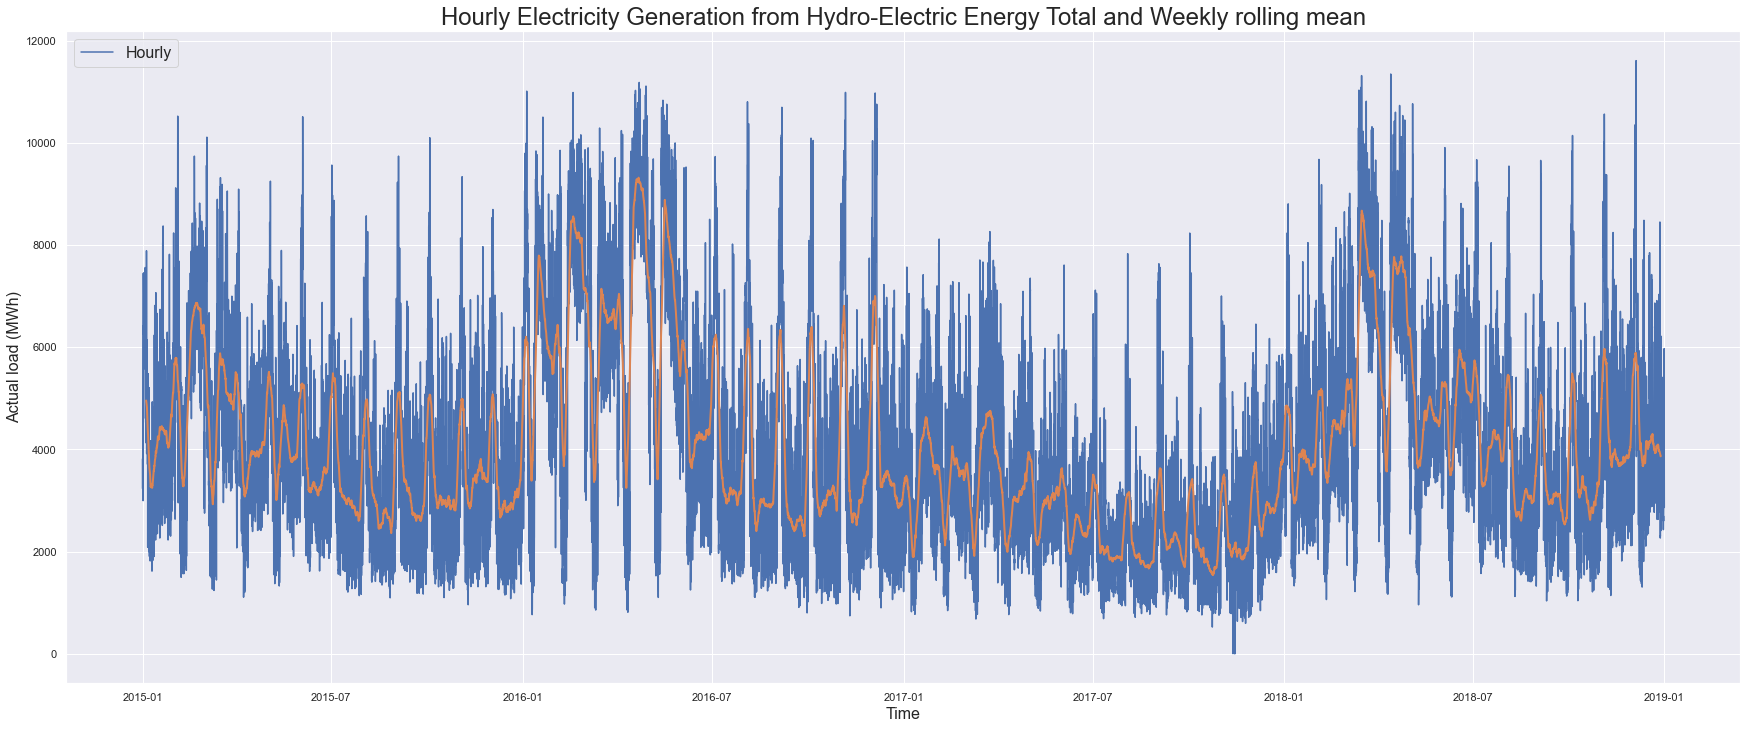

In [53]:
rolling4 = df_final['generation solar'].rolling(24 * 7, center=True).mean()
rolling5 = df_final['generation wind'].rolling(24 * 7, center=True).mean()
rolling6 = df_final['generation hydro'].rolling(24 * 7, center=True).mean()
ax4 = plot_series(df_final, 'generation solar', label='Hourly', ylabel='Actual load (MWh)',
                  title='Hourly Electricity Generation from Solar Energy Total and Weekly rolling mean')
ax5 = plot_series(df_final, 'generation wind', label='Hourly', ylabel='Actual load (MWh)',
                  title='Hourly Electricity Generation from Wind Energy Total and Weekly rolling mean')
ax6 = plot_series(df_final, 'generation hydro', label='Hourly', ylabel='Actual load (MWh)',
                  title='Hourly Electricity Generation from Hydro-Electric Energy Total and Weekly rolling mean')
ax4.plot(rolling4, linestyle='-', linewidth=2, label='Weekly rolling mean')
ax5.plot(rolling5, linestyle='-', linewidth=2, label='Weekly rolling mean')
ax6.plot(rolling6, linestyle='-', linewidth=2, label='Weekly rolling mean')

plt.show()

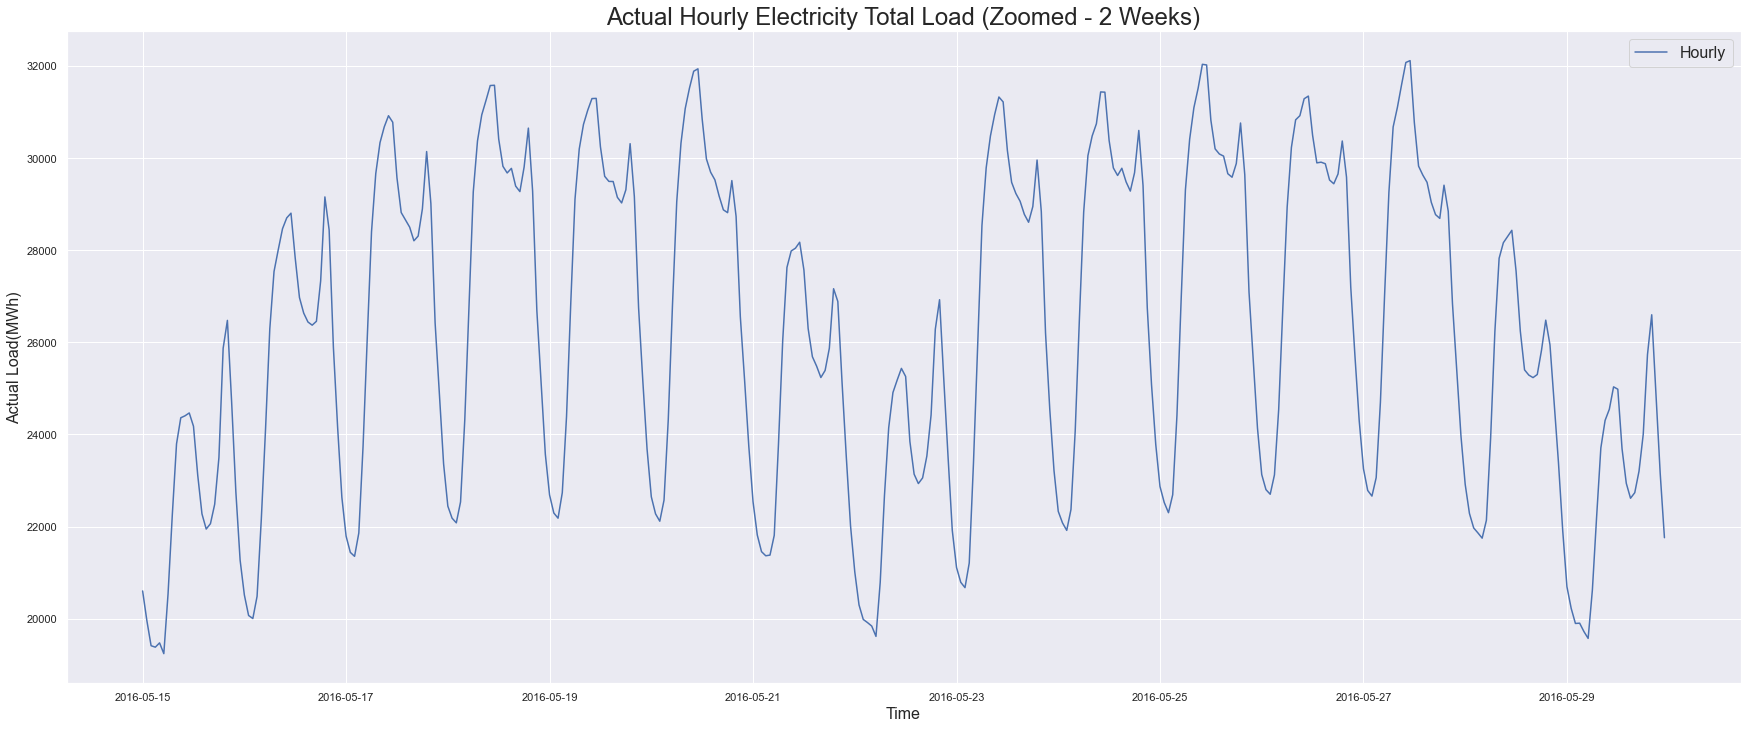

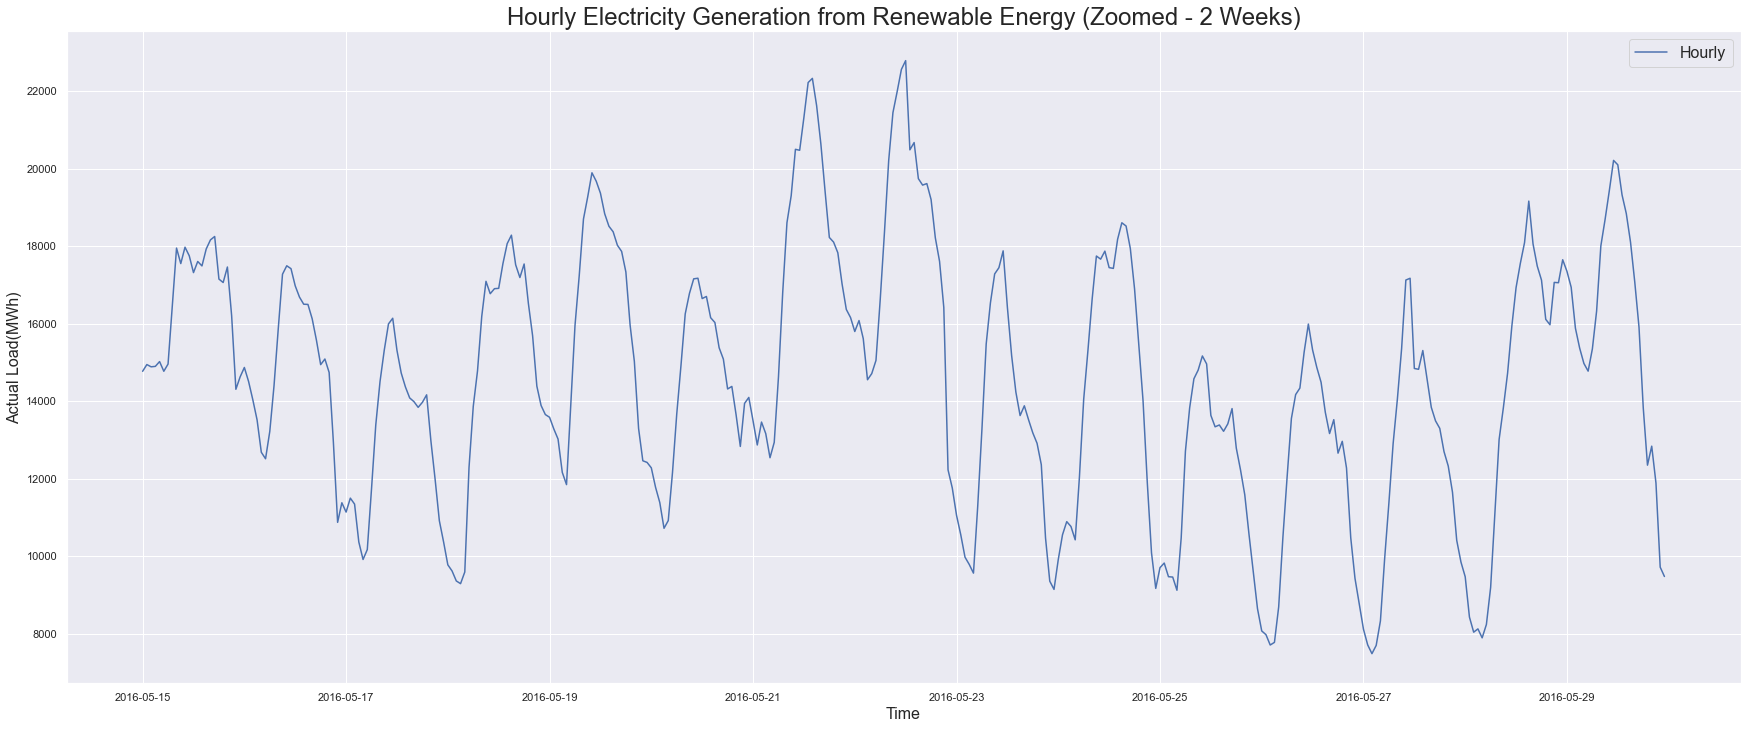

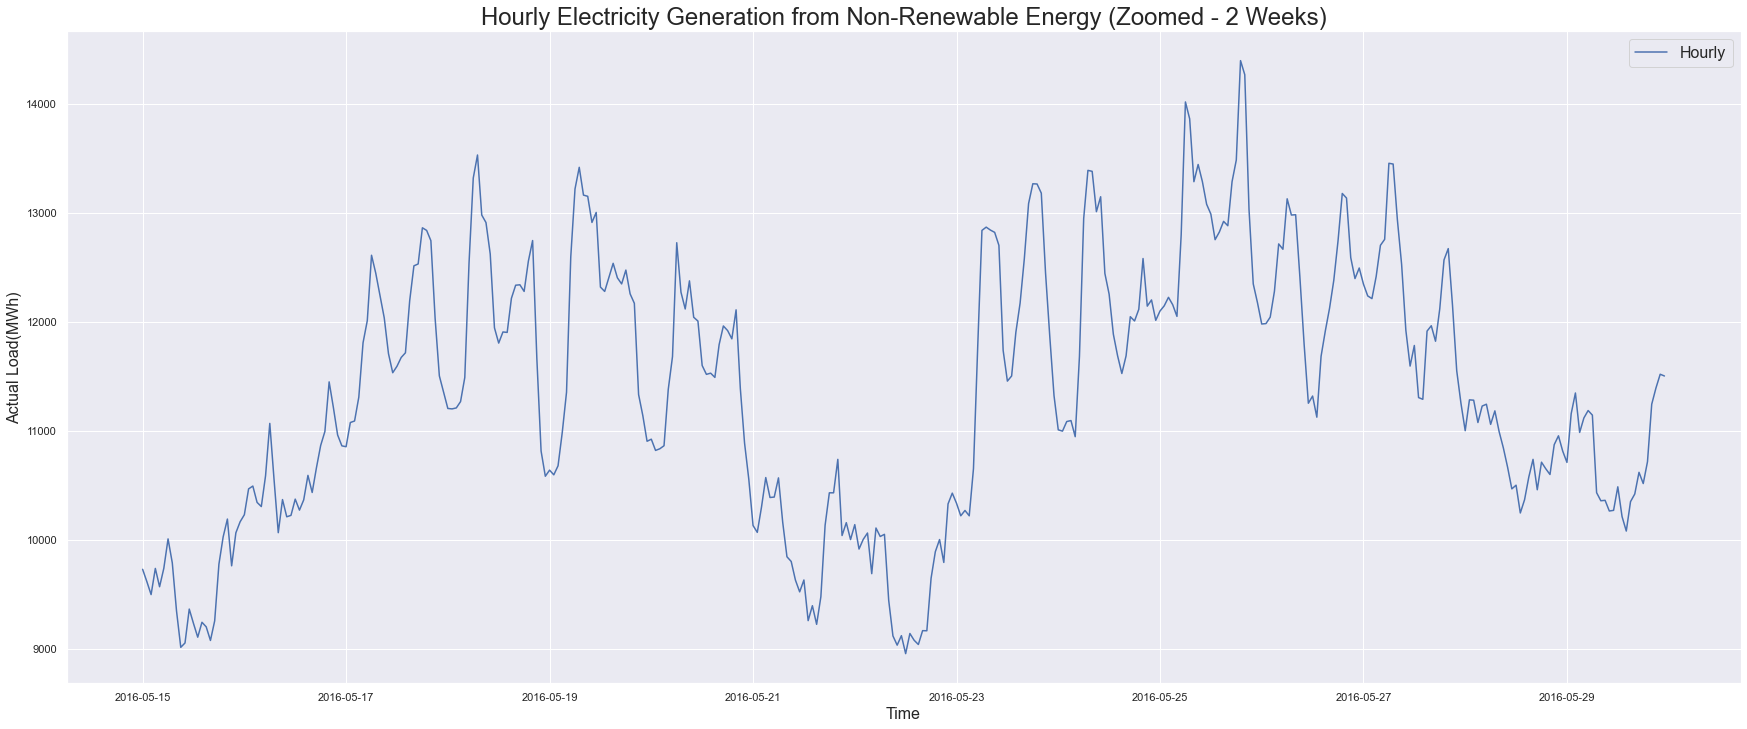

In [54]:
# Plot the actual electricity total load at a daily/weekly scale

ax1 = plot_series(df_final, 'total load actual', label='Hourly', ylabel='Actual Load(MWh)',
                  start=1 + 24 * 500, end=1 + 24 * 515,
                  title='Actual Hourly Electricity Total Load (Zoomed - 2 Weeks)')
ax2 = plot_series(df_final, 'generation renewable', label='Hourly', ylabel='Actual Load(MWh)',
                  start=1 + 24 * 500, end=1 + 24 * 515,
                  title='Hourly Electricity Generation from Renewable Energy (Zoomed - 2 Weeks)')
ax3 = plot_series(df_final, 'generation non-renewable', label='Hourly', ylabel='Actual Load(MWh)',
                  start=1 + 24 * 500, end=1 + 24 * 515,
                  title='Hourly Electricity Generation from Non-Renewable Energy (Zoomed - 2 Weeks)')
plt.show()

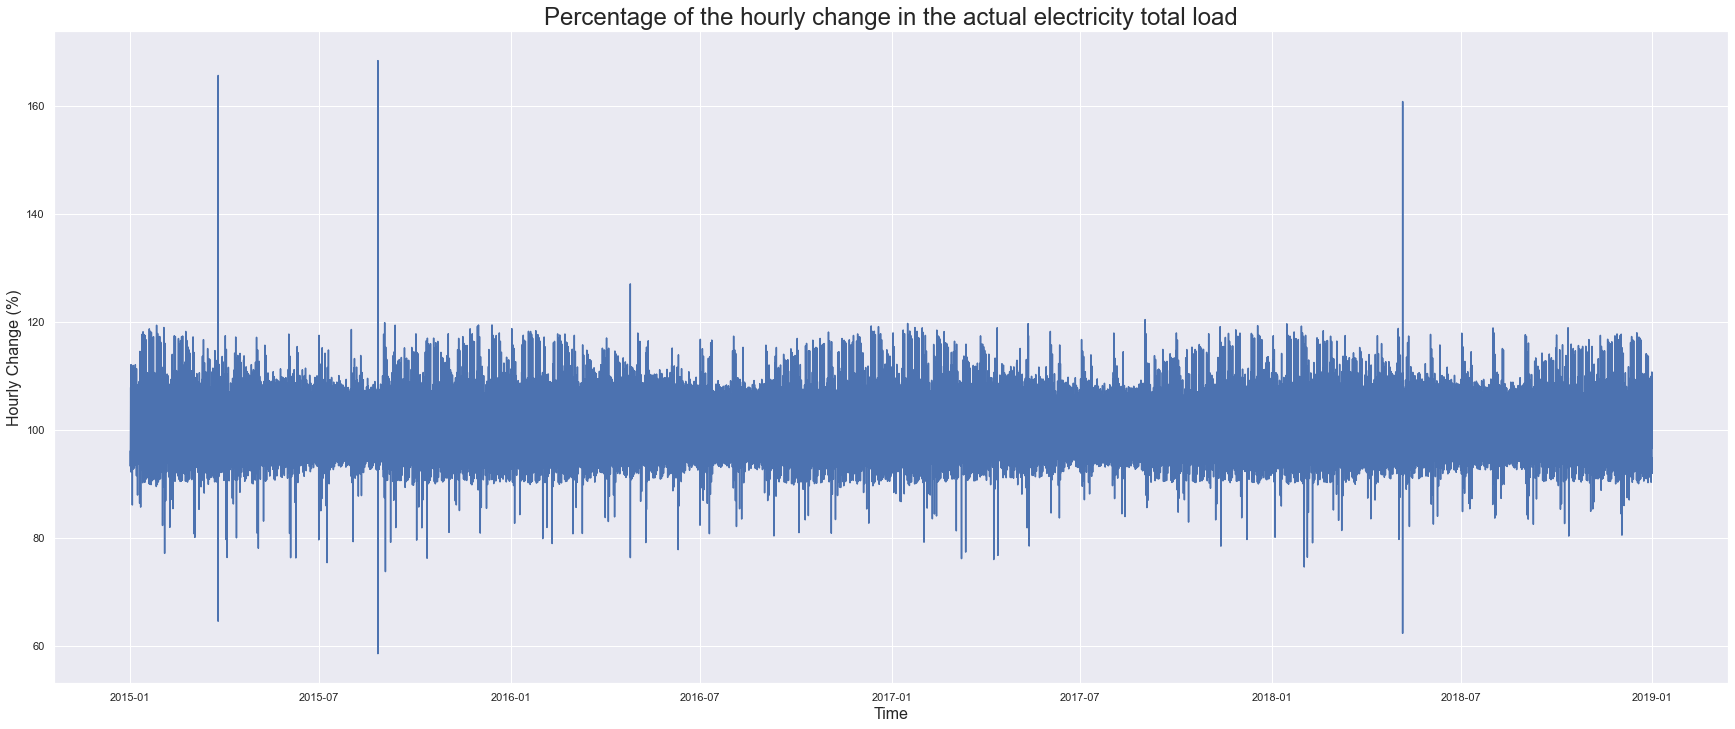

In [55]:
# Plot the percentage of the hourly change in the actual electricity load

change = df_energy['total load actual'].div(df_energy['total load actual'].shift(1)).mul(100)
ax = plot_series(series=change, ylabel='Hourly Change (%)',
                 title='Percentage of the hourly change in the actual electricity total load')
plt.show()

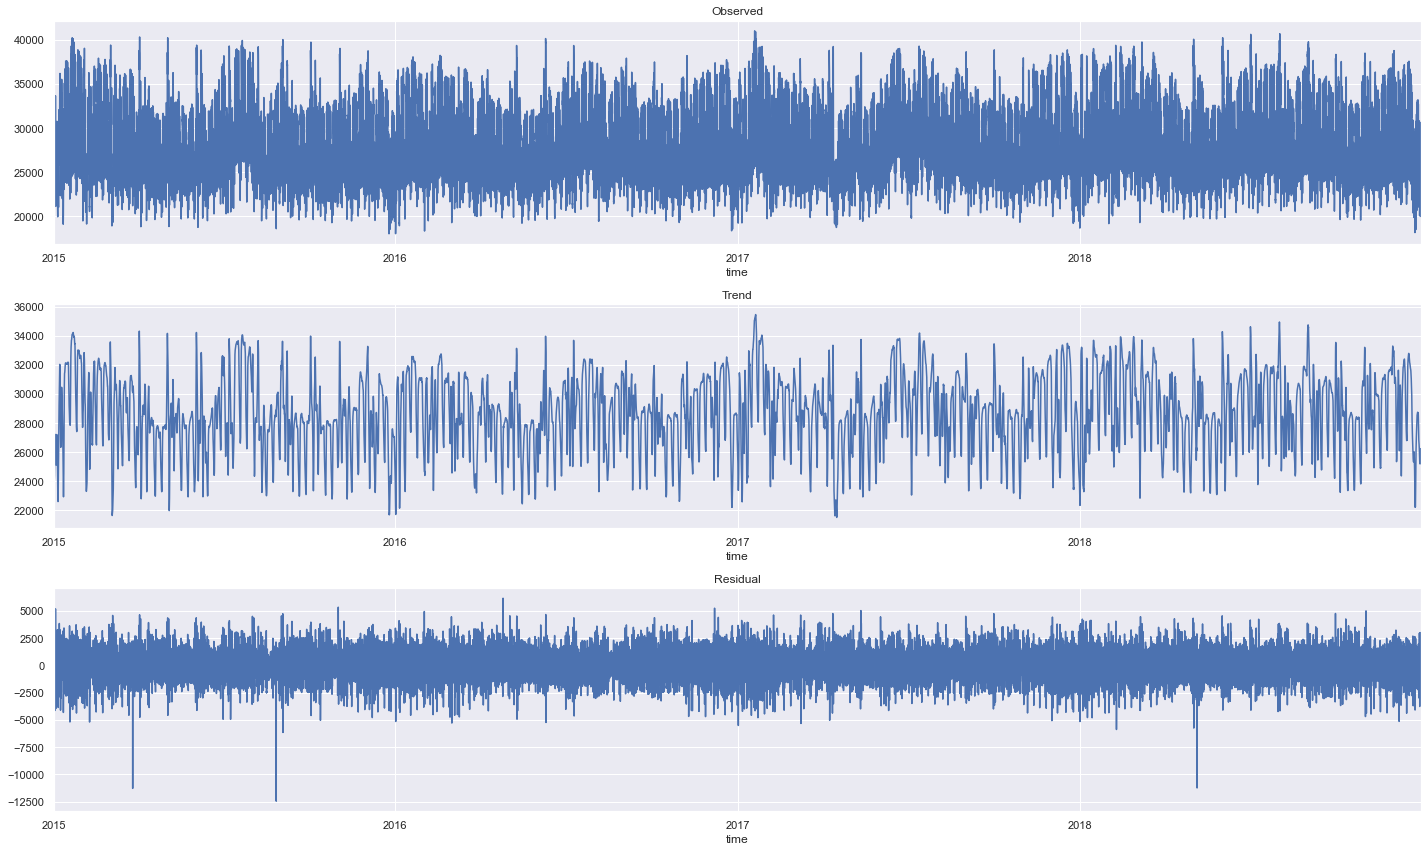

In [56]:
# Decompose the electricity load time series

res = sm.tsa.seasonal_decompose(df_energy['total load actual'], model='additive')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
plt.tight_layout()
plt.show()

In [57]:
df_global = df_final[['generation biomass', 'generation fossil gas', 'generation fossil oil', 'generation nuclear', 'generation other', 'generation solar', 'generation wind', 'generation hydro', 'generation other renewable', 'generation renewable', 'generation non-renewable', 'total load actual', 'temp', 'temp_min', 'temp_max', 'pressure','humidity', 'wind_speed', 'rain_1h', 'snow_3h', 'clouds_all']]

In [58]:
df_global.to_csv('C:\\Users\\loren\\PycharmProjects\\Bayes\\National.csv')

In [59]:
#NEURAL NETWORKS

In [60]:
scaler = MinMaxScaler()

In [61]:
columns = ['temp_min', 'temp', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'snow_3h',
         'clouds_all', 'generation solar', 'generation hydro', 'generation wind',
         'generation other renewable', 'generation biomass', 'generation fossil gas', 'generation fossil oil', 'generation nuclear', 'generation other']

In [62]:
#NN NAZIONALE SENZA NON RINNOVABILI

In [63]:
nng = df_global[['temp_min', 'temp', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'snow_3h',
         'clouds_all', 'generation solar', 'generation hydro', 'generation wind',
         'generation other renewable', 'generation biomass', 'generation fossil gas', 'generation fossil oil', 'generation nuclear', 'generation other']]
nng = scaler.fit_transform(nng)

In [64]:
dataset = pd.DataFrame(nng, columns = columns)

In [65]:
inputs = ['temp_min', 'temp', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'snow_3h']
outputs = ['generation solar', 'generation hydro', 'generation wind', 'generation other renewable']

x = dataset[inputs]
y = dataset[outputs]

In [66]:
tfk = tf.keras
tf.keras.backend.set_floatx("float64")
tfd = tfp.distributions

In [67]:
tf.config.list_physical_devices("GPU")

[]

In [68]:
# Define helper functions.
detector = IsolationForest(n_estimators=1000, random_state=42)
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [69]:
# Define some hyperparameters.
n_epochs, n_batches, n_samples = 25, 16, dataset.shape[0]
buffer_size, batch_size = n_samples, np.floor(n_samples/n_batches)

In [70]:
# Define training and test data sizes.
n_train = int(0.70*dataset.shape[0])
n_train

24544

In [71]:
# Define dataset instance.
data = tf.data.Dataset.from_tensor_slices((dataset[inputs].values, dataset[outputs].values))
data = data.shuffle(n_samples, reshuffle_each_iteration=True)

In [72]:
# Define train and test data instances.
data_train = data.take(n_train).batch(batch_size).repeat(n_epochs)
data_test = data.skip(n_train).batch(1)

In [73]:
# Define prior for regularization.
gauss_prior = tfd.Normal(
    loc = tf.zeros( len(outputs), dtype=tf.float64 ),
    scale = 1.0, #tf.ones( len(outputs), dtype=tf.float64 ),
    name = "p_normal",
    )

prior = tfd.Independent(
    gauss_prior,
    reinterpreted_batch_ndims = 1,
    name = "prior",
    )

regularizer = tfp.layers.KLDivergenceRegularizer(prior, weight=1/n_batches, ) # Kullback–Leibler divergence (also called relative entropy)

In [74]:
# Define model instance.
model = tfk.Sequential([
    tfk.layers.InputLayer(
        input_shape=(len(inputs),),
    name="input"),
    # dense for inputs
    tfk.layers.Dense(
        n_batches,
    activation="relu", name="dense_input"),
    # dense for weights
    tfk.layers.Dense(
        tfp.layers.MultivariateNormalTriL.params_size(len(outputs)), # uncertainty in the parameters weights
    activation=None, name="distribution_weights"),
    # (declaration of the) posterior probability distribution structure
    tfp.layers.MultivariateNormalTriL(
        len(outputs), activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1/n_batches), # activity_regularizer acts as prior for the output layer
    name="output")
], name="model")

In [75]:
log_dir = "logs/fit/" + 'nnN basic'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [76]:
# Compile model.
model.compile(optimizer="adam", loss=neg_log_likelihood)

In [77]:
layer_weights = dict()

In [78]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f" ... i'm gonna pickle the model: ")

        # model.save_weights(f'epoches/weights.{epoch:02}')
        # model.save(f'epoches/model.{epoch:02}')

        for l in ['dense_input', 'distribution_weights', 'output']:
            layer_weights[epoch, l] = model.get_layer(l).weights

        print(f'epoch #{epoch:02} pickled!')


In [79]:
# Run training session.
model.fit(data_train, epochs=n_epochs, validation_data=data_test, verbose=True, callbacks=[CustomCallback(), tensorboard_callback])

Epoch 1/25
297/300 [============================>.] - ETA: 0s - loss: 0.7378 ... i'm gonna pickle the model: 
epoch #00 pickled!
300/300 [==============================] - 15s 41ms/step - loss: 0.7263 - val_loss: -0.7249
Epoch 2/25
300/300 [==============================] - ETA: 0s - loss: -0.8107 ... i'm gonna pickle the model: 
epoch #01 pickled!
300/300 [==============================] - 15s 50ms/step - loss: -0.8107 - val_loss: -0.8468
Epoch 3/25
298/300 [============================>.] - ETA: 0s - loss: -0.8744 ... i'm gonna pickle the model: 
epoch #02 pickled!
300/300 [==============================] - 12s 41ms/step - loss: -0.8745 - val_loss: -0.8813
Epoch 4/25
298/300 [============================>.] - ETA: 0s - loss: -0.9030 ... i'm gonna pickle the model: 
epoch #03 pickled!
300/300 [==============================] - 13s 44ms/step - loss: -0.9030 - val_loss: -0.8937
Epoch 5/25
297/300 [============================>.] - ETA: 0s - loss: -0.9247 ... i'm gonna pickle the model: 

In [80]:
# Describe model.
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_input (Dense)         (None, 16)                144       
                                                                 
 distribution_weights (Dense  (None, 14)               238       
 )                                                               
                                                                 
 output (MultivariateNormalT  ((None, 4),              0         
 riL)                         (None, 4))                         
                                                                 
Total params: 382
Trainable params: 382
Non-trainable params: 0
_________________________________________________________________


In [81]:
pickle.dump(layer_weights, open('layer.weights.foreach.epoch.pkl', 'wb'))

In [82]:
#tfp.layers.DenseFlipout(32, activation="relu", name="dense_1")

In [83]:
# Predict.
samples = 1000
iterations = 10
test_iterator = tf.compat.v1.data.make_one_shot_iterator(data_test)
X_true1, Y_true1, Y_pred1 = np.empty(shape=(samples, len(inputs))), np.empty(shape=(samples, len(outputs))), np.empty(
    shape=(samples, len(outputs), iterations))

In [84]:
for i in range(samples):
    features, labels = test_iterator.get_next()
    X_true1[i,:] = features
    Y_true1[i,:] = labels.numpy()
    for k in range(iterations):
        Y_pred1[i,:,k] = model.predict(features)

In [85]:
# Calculate mean and standard deviation.
Y_pred1_m = np.mean(Y_pred1, axis=-1)
Y_pred1_s = np.std(Y_pred1, axis=-1)
Y_pred1_m, Y_pred1_s

(array([[0.36692859, 0.35604862, 0.19105568, 0.69995978],
        [0.41983655, 0.40977213, 0.30695248, 0.78611555],
        [0.24366294, 0.44824565, 0.32210039, 0.56041032],
        ...,
        [0.48071978, 0.25236525, 0.29121375, 0.80312129],
        [0.06990548, 0.34966406, 0.27770727, 0.65437587],
        [0.48799496, 0.28114171, 0.27899509, 0.65963168]]),
 array([[0.36056722, 0.12422747, 0.15116108, 0.06482429],
        [0.31762157, 0.10054064, 0.13404357, 0.1404866 ],
        [0.18946407, 0.20042696, 0.18649786, 0.07520532],
        ...,
        [0.40482144, 0.13798277, 0.16027632, 0.16502101],
        [0.10818916, 0.12016539, 0.17179561, 0.10667729],
        [0.31063703, 0.15369585, 0.13476983, 0.10678944]]))

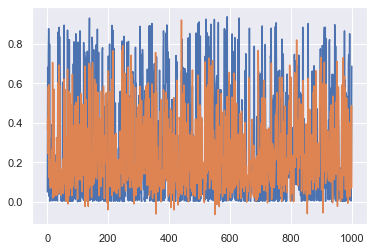

In [86]:
plt.plot(Y_true1[:,0])
plt.plot(Y_pred1_m[:,0])

plt.show()

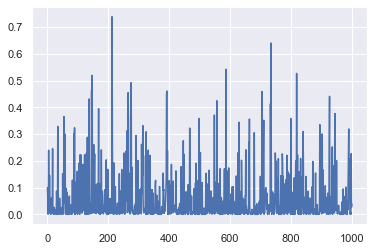

In [87]:
plt.plot((Y_true1[:,0] - Y_pred1_m[:,0])**2)

In [88]:
pickle.dump(Y_pred1, open('C:\\Users\\loren\\PycharmProjects\\Bayes\\pickle\\National_no_NonRenew_predict.pkl','wb'))

In [89]:
pickle.dump(Y_true1, open('C:\\Users\\loren\\PycharmProjects\\Bayes\\pickle\\National_no_NonRenew_true.pkl','wb'))

In [90]:
#NN NAZIONALE CON FLIPOUT NO NON RINNOVABILI

In [91]:
# Define some hyperparameters.
n_epochs, n_batches, n_samples = 25, 16, dataset.shape[0]
buffer_size, batch_size = n_samples, np.floor(n_samples / n_batches)

In [92]:
# Define training and test data sizes.
n_train = int(0.70 * dataset.shape[0])
n_train

24544

In [93]:
# Define dataset instance.
data = tf.data.Dataset.from_tensor_slices((dataset[inputs].values, dataset[outputs].values))
data = data.shuffle(n_samples, reshuffle_each_iteration=True)

In [94]:
# Define train and test data instances.
data_train = data.take(n_train).batch(batch_size).repeat(n_epochs)
data_test = data.skip(n_train).batch(1)

In [95]:
# Define model instance.
model = tfk.Sequential([
    tfk.layers.InputLayer(
        input_shape=(len(inputs),),
        name="input"),
    # dense for inputs
    tfk.layers.Dense(
        n_batches,
        activation="relu", name="dense_input"),
    # a new dense for input
    tfp.layers.DenseFlipout(
        10,
        activation="relu",
        name="dense_1"
    ),
    # dense for weights
    tfk.layers.Dense(
        tfp.layers.MultivariateNormalTriL.params_size(len(outputs)),  # uncertainty in the parameters weights
        activation=None, name="distribution_weights"),
    # (declaration of the) posterior probability distribution structure
    tfp.layers.MultivariateNormalTriL(
        len(outputs), activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1 / n_batches),
        # activity_regularizer acts as prior for the output layer
        name="output")
], name="model")

C:\Users\loren\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_probability\python\layers\util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
C:\Users\loren\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_probability\python\layers\util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


In [96]:
log_dir = "logs/fit/" + 'nnN + flipout'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [97]:
# Compile model.
model.compile(optimizer="adam", loss=neg_log_likelihood)

In [98]:
layer_weights = dict()

In [99]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f" ... i'm gonna pickle the model: ")

        # model.save_weights(f'epoches/weights.{epoch:02}')
        # model.save(f'epoches/model.{epoch:02}')

        for l in ['dense_input', 'distribution_weights', 'output']:
            layer_weights[epoch, l] = model.get_layer(l).weights

        print(f'epoch #{epoch:02} pickled!')



In [100]:
# Run training session.
model.fit(data_train, epochs=n_epochs, validation_data=data_test, verbose=True,
          callbacks=[CustomCallback(), tensorboard_callback])

Epoch 1/25
297/300 [============================>.] - ETA: 0s - loss: 380.6304 ... i'm gonna pickle the model: 
epoch #00 pickled!
300/300 [==============================] - 17s 49ms/step - loss: 380.4370 - val_loss: 355.6817
Epoch 2/25
297/300 [============================>.] - ETA: 0s - loss: 332.9226 ... i'm gonna pickle the model: 
epoch #01 pickled!
300/300 [==============================] - 16s 52ms/step - loss: 332.7428 - val_loss: 309.7248
Epoch 3/25
298/300 [============================>.] - ETA: 0s - loss: 287.4987 ... i'm gonna pickle the model: 
epoch #02 pickled!
300/300 [==============================] - 11s 37ms/step - loss: 287.4039 - val_loss: 265.0899
Epoch 4/25
297/300 [============================>.] - ETA: 0s - loss: 243.8076 ... i'm gonna pickle the model: 
epoch #03 pickled!
300/300 [==============================] - 11s 37ms/step - loss: 243.6405 - val_loss: 222.2299
Epoch 5/25
298/300 [============================>.] - ETA: 0s - loss: 201.8454 ... i'm gonna pic

In [101]:
# Describe model.
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_input (Dense)         (None, 16)                144       
                                                                 
 dense_1 (DenseFlipout)      (None, 10)                330       
                                                                 
 distribution_weights (Dense  (None, 14)               154       
 )                                                               
                                                                 
 output (MultivariateNormalT  ((None, 4),              0         
 riL)                         (None, 4))                         
                                                                 
Total params: 628
Trainable params: 628
Non-trainable params: 0
_________________________________________________________________


In [102]:
pickle.dump(layer_weights, open('layer.weights.foreach.epoch.pkl', 'wb'))

In [103]:
#tfp.layers.DenseFlipout(32, activation="relu", name="dense_1")
# Predict.
samples = 1000
iterations = 10
test_iterator = tf.compat.v1.data.make_one_shot_iterator(data_test)
X_true6, Y_true6, Y_pred6 = np.empty(shape=(samples, len(inputs))), np.empty(shape=(samples, len(outputs))), np.empty(
    shape=(samples, len(outputs), iterations))

In [104]:
for i in range(samples):
    features, labels = test_iterator.get_next()
    X_true6[i, :] = features
    Y_true6[i, :] = labels.numpy()
    for k in range(iterations):
        Y_pred6[i, :, k] = model.predict(features)

In [105]:
# Calculate mean and standard deviation.
Y_pred6_m = np.mean(Y_pred1, axis=-1)
Y_pred6_s = np.std(Y_pred1, axis=-1)
Y_pred6_m, Y_pred6_s

(array([[0.36692859, 0.35604862, 0.19105568, 0.69995978],
        [0.41983655, 0.40977213, 0.30695248, 0.78611555],
        [0.24366294, 0.44824565, 0.32210039, 0.56041032],
        ...,
        [0.48071978, 0.25236525, 0.29121375, 0.80312129],
        [0.06990548, 0.34966406, 0.27770727, 0.65437587],
        [0.48799496, 0.28114171, 0.27899509, 0.65963168]]),
 array([[0.36056722, 0.12422747, 0.15116108, 0.06482429],
        [0.31762157, 0.10054064, 0.13404357, 0.1404866 ],
        [0.18946407, 0.20042696, 0.18649786, 0.07520532],
        ...,
        [0.40482144, 0.13798277, 0.16027632, 0.16502101],
        [0.10818916, 0.12016539, 0.17179561, 0.10667729],
        [0.31063703, 0.15369585, 0.13476983, 0.10678944]]))

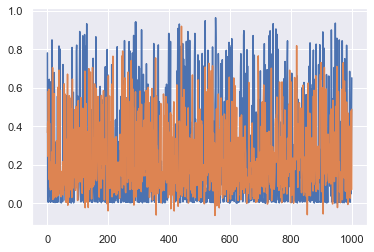

In [106]:
plt.plot(Y_true6[:, 0])
plt.plot(Y_pred6_m[:, 0])

plt.show()

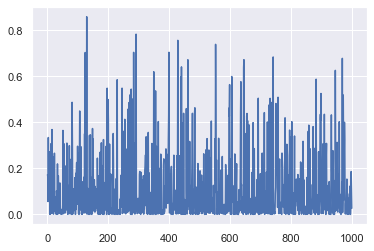

In [107]:
plt.plot((Y_true6[:, 0] - Y_pred6_m[:, 0]) ** 2)

In [108]:
pickle.dump(Y_pred6, open('C:\\Users\\loren\\PycharmProjects\\Bayes\\pickle\\National_no_NonRenew_flipout_predict.pkl','wb'))

In [109]:
#NN NAZIONALE CON NON RINNOVABILI

In [110]:
nng = df_global[['temp_min', 'temp', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'snow_3h',
                 'clouds_all', 'generation solar', 'generation hydro', 'generation wind',
                 'generation other renewable', 'generation biomass', 'generation fossil gas', 'generation fossil oil',
                 'generation nuclear', 'generation other']]
nng = scaler.fit_transform(nng)

In [111]:
dataset = pd.DataFrame(nng, columns=columns)

In [112]:
inputs = ['temp_min', 'temp', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'snow_3h', 'generation biomass', 'generation fossil gas', 'generation fossil oil', 'generation nuclear', 'generation other']
outputs = ['generation solar', 'generation hydro', 'generation wind', 'generation other renewable']

x = dataset[inputs]
y = dataset[outputs]

In [113]:
# Define helper functions.
detector = IsolationForest(n_estimators=1000, random_state=42)
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [114]:
# Define some hyperparameters.
n_epochs, n_batches, n_samples = 25, 16, dataset.shape[0]
buffer_size, batch_size = n_samples, np.floor(n_samples / n_batches)

In [115]:
# Define training and test data sizes.
n_train = int(0.70 * dataset.shape[0])
n_train

24544

In [116]:
# Define dataset instance.
data = tf.data.Dataset.from_tensor_slices((dataset[inputs].values, dataset[outputs].values))
data = data.shuffle(n_samples, reshuffle_each_iteration=True)

In [117]:
# Define train and test data instances.
data_train = data.take(n_train).batch(batch_size).repeat(n_epochs)
data_test = data.skip(n_train).batch(1)

In [118]:
# Define prior for regularization.
gauss_prior = tfd.Normal(
    loc = tf.zeros( len(outputs), dtype=tf.float64 ),
    scale = 1.0, #tf.ones( len(outputs), dtype=tf.float64 ),
    name = "p_normal",
    )

prior = tfd.Independent(
    gauss_prior,
    reinterpreted_batch_ndims = 1,
    name = "prior",
    )

regularizer = tfp.layers.KLDivergenceRegularizer(prior, weight=1/n_batches, ) # Kullback–Leibler divergence (also called relative entropy)

In [119]:
# Define model instance.
model = tfk.Sequential([
    tfk.layers.InputLayer(
        input_shape=(len(inputs),),
        name="input"),
    # dense for inputs
    tfk.layers.Dense(
        n_batches,
        activation="relu", name="dense_input"),
    # # a new dense for input
    #tfp.layers.DenseFlipout(
    #    10,
    #    activation="relu",
    #    name="dense_1"
    #),
    # dense for weights
    tfk.layers.Dense(
        tfp.layers.MultivariateNormalTriL.params_size(len(outputs)),  # uncertainty in the parameters weights
        activation=None, name="distribution_weights"),
    # (declaration of the) posterior probability distribution structure
    tfp.layers.MultivariateNormalTriL(
        len(outputs), activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1 / n_batches),
        # activity_regularizer acts as prior for the output layer
        name="output")
], name="model")

In [120]:
# Compile model.
model.compile(optimizer="adam", loss=neg_log_likelihood)

In [121]:
log_dir = "logs/fit/" + 'nnN + NR'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [122]:
layer_weights = dict()

In [123]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f" ... i'm gonna pickle the model: ")

        # model.save_weights(f'epoches/weights.{epoch:02}')
        # model.save(f'epoches/model.{epoch:02}')

        for l in ['dense_input', 'distribution_weights', 'output']:
            layer_weights[epoch, l] = model.get_layer(l).weights

        print(f'epoch #{epoch:02} pickled!')

In [124]:
# Run training session.
model.fit(data_train, epochs=n_epochs, validation_data=data_test, verbose=True, callbacks=[CustomCallback(), tensorboard_callback])

Epoch 1/25
299/300 [============================>.] - ETA: 0s - loss: 1.0875 ... i'm gonna pickle the model: 
epoch #00 pickled!
300/300 [==============================] - 18s 52ms/step - loss: 1.0863 - val_loss: -0.6088
Epoch 2/25
298/300 [============================>.] - ETA: 0s - loss: -0.9085 ... i'm gonna pickle the model: 
epoch #01 pickled!
300/300 [==============================] - 15s 50ms/step - loss: -0.9095 - val_loss: -1.0897
Epoch 3/25
299/300 [============================>.] - ETA: 0s - loss: -1.2230 ... i'm gonna pickle the model: 
epoch #02 pickled!
300/300 [==============================] - 15s 50ms/step - loss: -1.2231 - val_loss: -1.3031
Epoch 4/25
298/300 [============================>.] - ETA: 0s - loss: -1.3321 ... i'm gonna pickle the model: 
epoch #03 pickled!
300/300 [==============================] - 15s 51ms/step - loss: -1.3321 - val_loss: -1.3644
Epoch 5/25
300/300 [==============================] - ETA: 0s - loss: -1.4053 ... i'm gonna pickle the model: 

In [125]:
# Describe model.
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_input (Dense)         (None, 16)                224       
                                                                 
 distribution_weights (Dense  (None, 14)               238       
 )                                                               
                                                                 
 output (MultivariateNormalT  ((None, 4),              0         
 riL)                         (None, 4))                         
                                                                 
Total params: 462
Trainable params: 462
Non-trainable params: 0
_________________________________________________________________


In [126]:
pickle.dump(layer_weights, open('layer.weights.foreach.epoch.pkl', 'wb'))

In [127]:
#tfp.layers.DenseFlipout(32, activation="relu", name="dense_1")

In [128]:
# Predict.
samples = 1000
iterations = 10
test_iterator = tf.compat.v1.data.make_one_shot_iterator(data_test)
X_true2, Y_true2, Y_pred2 = np.empty(shape=(samples, len(inputs))), np.empty(shape=(samples, len(outputs))), np.empty(
    shape=(samples, len(outputs), iterations))

In [129]:
for i in range(samples):
    features, labels = test_iterator.get_next()
    X_true2[i, :] = features
    Y_true2[i, :] = labels.numpy()
    for k in range(iterations):
        Y_pred2[i, :, k] = model.predict(features)

In [130]:
# Calculate mean and standard deviation.
Y_pred2_m = np.mean(Y_pred2, axis=-1)
Y_pred2_s = np.std(Y_pred2, axis=-1)
Y_pred2_m, Y_pred2_s

(array([[0.23615917, 0.28839473, 0.30595013, 0.61961705],
        [0.64011895, 0.58095846, 0.5867388 , 0.60031666],
        [0.20460878, 0.22834675, 0.2180318 , 0.77097032],
        ...,
        [0.23082163, 0.4086133 , 0.48074187, 0.58647019],
        [0.03968302, 0.45069461, 0.10890958, 0.67421543],
        [0.0810786 , 0.42273509, 0.54344826, 0.59066541]]),
 array([[0.3327169 , 0.09792918, 0.16657252, 0.04525378],
        [0.59164069, 0.30346443, 0.34137901, 0.06456927],
        [0.18516021, 0.13868148, 0.16739229, 0.07224214],
        ...,
        [0.24535364, 0.23093527, 0.28136148, 0.04882352],
        [0.15422327, 0.13418838, 0.15404605, 0.05717902],
        [0.16681496, 0.11341617, 0.19881614, 0.07024016]]))

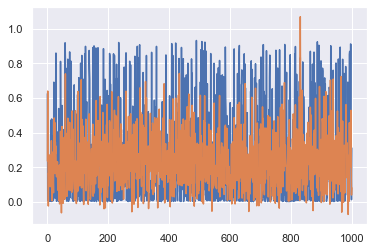

In [131]:
plt.plot(Y_true2[:, 0])
plt.plot(Y_pred2_m[:, 0])

plt.show()

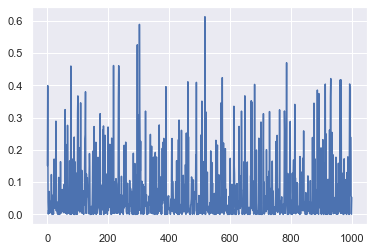

In [132]:
plt.plot((Y_true2[:, 0] - Y_pred2_m[:, 0]) ** 2)

In [133]:
pickle.dump(Y_pred2, open('C:\\Users\\loren\\PycharmProjects\\Bayes\\pickle\\National_whole_predict.pkl','wb'))

In [134]:
#NN NAZIONALE CON FLIPOUT

In [135]:
nng = df_global[['temp_min', 'temp', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'snow_3h',
                 'clouds_all', 'generation solar', 'generation hydro', 'generation wind',
                 'generation other renewable', 'generation biomass', 'generation fossil gas', 'generation fossil oil',
                 'generation nuclear', 'generation other']]
nng = scaler.fit_transform(nng)

In [136]:
dataset = pd.DataFrame(nng, columns=columns)

In [137]:
# Define helper functions.
detector = IsolationForest(n_estimators=1000, random_state=42)
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [138]:
inputs = ['temp_min', 'temp', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'snow_3h',
          'generation biomass', 'generation fossil gas', 'generation fossil oil', 'generation nuclear',
          'generation other']
outputs = ['generation solar', 'generation hydro', 'generation wind', 'generation other renewable']

x = dataset[inputs]
y = dataset[outputs]

In [139]:
# Define some hyperparameters.
n_epochs, n_batches, n_samples = 25, 16, dataset.shape[0]
buffer_size, batch_size = n_samples, np.floor(n_samples / n_batches)

In [140]:
# Define training and test data sizes.
n_train = int(0.70 * dataset.shape[0])
n_train

24544

In [141]:
# Define dataset instance.
data = tf.data.Dataset.from_tensor_slices((dataset[inputs].values, dataset[outputs].values))
data = data.shuffle(n_samples, reshuffle_each_iteration=True)

In [142]:
# Define train and test data instances.
data_train = data.take(n_train).batch(batch_size).repeat(n_epochs)
data_test = data.skip(n_train).batch(1)

In [143]:
# Define prior for regularization.
gauss_prior = tfd.Normal(
    loc=tf.zeros(len(outputs), dtype=tf.float64),
    scale=1.0,  #tf.ones( len(outputs), dtype=tf.float64 ),
    name="p_normal",
)

prior = tfd.Independent(
    gauss_prior,
    reinterpreted_batch_ndims=1,
    name="prior",
)

regularizer = tfp.layers.KLDivergenceRegularizer(prior,
                                                 weight=1 / n_batches, )  # Kullback–Leibler divergence (also called relative entropy)

In [144]:
# Define model instance.
model = tfk.Sequential([
    tfk.layers.InputLayer(
        input_shape=(len(inputs),),
        name="input"),
    # dense for inputs
    tfk.layers.Dense(
        n_batches,
        activation="relu", name="dense_input"),
    # a new dense for input
    tfp.layers.DenseFlipout(
        10,
        activation="relu",
        name="dense_1"
    ),
    # dense for weights
    tfk.layers.Dense(
        tfp.layers.MultivariateNormalTriL.params_size(len(outputs)),  # uncertainty in the parameters weights
        activation=None, name="distribution_weights"),
    # (declaration of the) posterior probability distribution structure
    tfp.layers.MultivariateNormalTriL(
        len(outputs), activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1 / n_batches),
        # activity_regularizer acts as prior for the output layer
        name="output")
], name="model")

C:\Users\loren\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_probability\python\layers\util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
C:\Users\loren\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_probability\python\layers\util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


In [145]:
# Compile model.
model.compile(optimizer="adam", loss=neg_log_likelihood)

In [146]:
log_dir = "logs/fit/" + 'nnN + NR + flipout'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [147]:
layer_weights = dict()

In [148]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f" ... i'm gonna pickle the model: ")

        # model.save_weights(f'epoches/weights.{epoch:02}')
        # model.save(f'epoches/model.{epoch:02}')

        for l in ['dense_input', 'distribution_weights', 'output']:
            layer_weights[epoch, l] = model.get_layer(l).weights

        print(f'epoch #{epoch:02} pickled!')

In [149]:
#checkpoint_path = "C:\\Users\\loren\\PycharmProjects\\Bayes\\cp_flipout.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)

In [150]:
# Create a callback that saves the model's weights
#cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                 save_weights_only=True,
#                                                 verbose=1)

In [151]:
model.fit(data_train, epochs=n_epochs, validation_data=data_test, verbose=True, callbacks=[CustomCallback(), tensorboard_callback])

Epoch 1/25
297/300 [============================>.] - ETA: 0s - loss: 381.7658 ... i'm gonna pickle the model: 
epoch #00 pickled!
300/300 [==============================] - 16s 49ms/step - loss: 381.5701 - val_loss: 356.4978
Epoch 2/25
297/300 [============================>.] - ETA: 0s - loss: 333.7064 ... i'm gonna pickle the model: 
epoch #01 pickled!
300/300 [==============================] - 14s 46ms/step - loss: 333.5264 - val_loss: 310.4891
Epoch 3/25
297/300 [============================>.] - ETA: 0s - loss: 288.3241 ... i'm gonna pickle the model: 
epoch #02 pickled!
300/300 [==============================] - 15s 50ms/step - loss: 288.1499 - val_loss: 265.8379
Epoch 4/25
297/300 [============================>.] - ETA: 0s - loss: 244.5342 ... i'm gonna pickle the model: 
epoch #03 pickled!
300/300 [==============================] - 15s 50ms/step - loss: 244.3670 - val_loss: 222.9386
Epoch 5/25
299/300 [============================>.] - ETA: 0s - loss: 202.4780 ... i'm gonna pic

In [152]:
# Describe model.
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_input (Dense)         (None, 16)                224       
                                                                 
 dense_1 (DenseFlipout)      (None, 10)                330       
                                                                 
 distribution_weights (Dense  (None, 14)               154       
 )                                                               
                                                                 
 output (MultivariateNormalT  ((None, 4),              0         
 riL)                         (None, 4))                         
                                                                 
Total params: 708
Trainable params: 708
Non-trainable params: 0
_________________________________________________________________


In [153]:
pickle.dump(layer_weights, open('layer.weights.foreach.epoch.pkl', 'wb'))

In [154]:
# Predict.
samples = 1000
iterations = 10
test_iterator = tf.compat.v1.data.make_one_shot_iterator(data_test)
X_true3, Y_true3, Y_pred3 = np.empty(shape=(samples, len(inputs))), np.empty(shape=(samples, len(outputs))), np.empty(
    shape=(samples, len(outputs), iterations))

In [155]:
for i in range(samples):
    features, labels = test_iterator.get_next()
    X_true3[i, :] = features
    Y_true3[i, :] = labels.numpy()
    for k in range(iterations):
        Y_pred3[i, :, k] = model.predict(features)

In [156]:
# Calculate mean and standard deviation.
Y_pred3_m = np.mean(Y_pred3, axis=-1)
Y_pred3_s = np.std(Y_pred3, axis=-1)
Y_pred3_m, Y_pred3_s

(array([[0.27946686, 0.31719201, 0.20474989, 0.72997506],
        [0.38211074, 0.21264405, 0.37063141, 0.76421098],
        [0.18595946, 0.50824228, 0.46970335, 0.71825889],
        ...,
        [0.30494241, 0.34081034, 0.22449382, 0.74127616],
        [0.24987448, 0.34334017, 0.34267065, 0.74150506],
        [0.15569907, 0.42238485, 0.35865888, 0.74877764]]),
 array([[0.25837045, 0.24816508, 0.20242372, 0.09182764],
        [0.28590923, 0.17154123, 0.22627825, 0.21420979],
        [0.27496385, 0.186395  , 0.14323811, 0.12290229],
        ...,
        [0.34222113, 0.1642359 , 0.2104869 , 0.07344223],
        [0.31304266, 0.18218821, 0.29115192, 0.13920514],
        [0.29684277, 0.17773751, 0.11837608, 0.10038775]]))

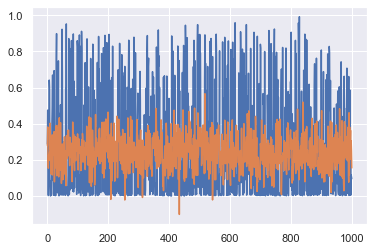

In [157]:
plt.plot(Y_true3[:, 0])
plt.plot(Y_pred3_m[:, 0])

plt.show()

In [158]:
pickle.dump(Y_pred3, open('C:\\Users\\loren\\PycharmProjects\\Bayes\\pickle\\National_flipout_predict.pkl','wb'))

In [159]:
pickle.dump(Y_true3, open('C:\\Users\\loren\\PycharmProjects\\Bayes\\National_flipout_true.pkl','wb'))

In [160]:
#latest = tf.train.latest_checkpoint(checkpoint_dir)
#latest

In [161]:
#dividere il df per ogni città

In [162]:
df_final = dict()

for city, df in df_weather.groupby('city_name'):
    df.drop('city_name', axis='columns', inplace=True)
    city_str = city.strip()

    df_final[city_str] = df.add_prefix(f'')
    df_final[city_str].rename(columns={'dt_iso':'time'}, inplace=True)

In [163]:
df_energy = df_energy.add_prefix(f'')
df_energy.rename(columns={'time': 'time'}, inplace=True)

In [164]:
df_energy.head()

,generation biomass,generation fossil gas,generation fossil oil,generation nuclear,generation other,generation other renewable,generation solar,generation waste,total load actual,price actual,generation coal,generation hydro,generation wind,generation non-renewable,generation renewable
time,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,4844.0,162.0,7096.0,43.0,73.0,49.0,196.0,25385.0,65.41,5150.0,3813.0,6378.0,17491.0,10760.0
2015-01-01 00:00:00+00:00,449.0,5196.0,158.0,7096.0,43.0,71.0,50.0,195.0,24382.0,64.92,5083.0,3587.0,5890.0,17771.0,10047.0
2015-01-01 01:00:00+00:00,448.0,4857.0,157.0,7099.0,43.0,73.0,50.0,196.0,22734.0,64.48,4904.0,3508.0,5461.0,17256.0,9540.0
2015-01-01 02:00:00+00:00,438.0,4314.0,160.0,7098.0,43.0,75.0,50.0,191.0,21286.0,59.32,4385.0,3231.0,5238.0,16191.0,9032.0
2015-01-01 03:00:00+00:00,428.0,4130.0,156.0,7097.0,43.0,74.0,42.0,189.0,20264.0,56.04,4027.0,3499.0,4935.0,15642.0,8978.0


In [165]:
df_final['Madrid'].head()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all
time,,,,,,,,,,,
2014-12-31 23:00:00+00:00,267.325,267.325,267.325,971.0,63.0,1.0,309.0,0.0,0.0,0.0,0.0
2015-01-01 00:00:00+00:00,267.325,267.325,267.325,971.0,63.0,1.0,309.0,0.0,0.0,0.0,0.0
2015-01-01 01:00:00+00:00,266.186,266.186,266.186,971.0,64.0,1.0,273.0,0.0,0.0,0.0,0.0
2015-01-01 02:00:00+00:00,266.186,266.186,266.186,971.0,64.0,1.0,273.0,0.0,0.0,0.0,0.0
2015-01-01 03:00:00+00:00,266.186,266.186,266.186,971.0,64.0,1.0,273.0,0.0,0.0,0.0,0.0


In [166]:
total_pop = 15272043
weights = {
    'Madrid': 6155116 / total_pop,
    'Barcelona': 5179243 / total_pop,
    'Valencia': 1645342 / total_pop,
    'Seville': 1305342 / total_pop,
    'Bilbao': 987000 / total_pop
}

In [167]:
for city, percent in weights.items():

    # trick di brumotti - togli la colonna, metti la colonna
    #tmp = df_energy.set_index('time')
    tmp = df_energy.astype(float) * percent
    tmp = tmp.reset_index()

    tmp = pd.merge(df_final[city], tmp, how='inner', left_on='time', right_on='time')

    tmp.to_csv(f'C:\\Users\\loren\\PycharmProjects\\Bayes\\splitted.splitted\\{city}.csv')

In [168]:
#fare nn per ogni città

In [174]:
bc = pd.read_csv('splitted.splitted\\Barcelona.csv')
bb = pd.read_csv('splitted.splitted\\Bilbao.csv')
md = pd.read_csv('splitted.splitted\\Madrid.csv')
sv = pd.read_csv('splitted.splitted\\Seville.csv')
vl = pd.read_csv('splitted.splitted\\Valencia.csv')

In [175]:
nnMD = md[['temp_min', 'temp', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'snow_3h',
         'clouds_all', 'generation solar', 'generation hydro', 'generation wind',
         'generation other renewable', 'generation biomass', 'generation fossil gas', 'generation fossil oil', 'generation nuclear', 'generation other']]

In [176]:
#NN per Madrid
nnMD = scaler.fit_transform(nnMD)
dataset = pd.DataFrame(nnMD, columns=columns)

In [177]:
inputs = ['temp_min', 'temp', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'snow_3h', 'generation biomass', 'generation fossil gas', 'generation fossil oil', 'generation nuclear', 'generation other']
outputs = ['generation solar', 'generation hydro', 'generation wind', 'generation other renewable']

x = dataset[inputs]
y = dataset[outputs]

In [178]:
# Define helper functions.
detector = IsolationForest(n_estimators=1000, random_state=42)
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [179]:
# Define some hyperparameters.
n_epochs, n_batches, n_samples = 25, 16, bc.shape[0]
buffer_size, batch_size = n_samples, np.floor(n_samples / n_batches)

In [180]:
# Define training and test data sizes.
n_train = int(0.70 * bc.shape[0])
n_train

24544

In [181]:
# Define dataset instance.
data = tf.data.Dataset.from_tensor_slices((dataset[inputs].values, dataset[outputs].values))
data = data.shuffle(n_samples, reshuffle_each_iteration=True)

In [182]:
# Define train and test data instances.
data_train = data.take(n_train).batch(batch_size).repeat(n_epochs)
data_test = data.skip(n_train).batch(1)

In [183]:
# Define prior for regularization.
gauss_prior = tfd.Normal(
    loc = tf.zeros( len(outputs), dtype=tf.float64 ),
    scale = 1.0, #tf.ones( len(outputs), dtype=tf.float64 ),
    name = "p_normal",
    )

prior = tfd.Independent(
    gauss_prior,
    reinterpreted_batch_ndims = 1,
    name = "prior",
    )

regularizer = tfp.layers.KLDivergenceRegularizer(prior, weight=1/n_batches, ) # Kullback–Leibler divergence (also called relative entropy)

In [184]:
# Define model instance.
model = tfk.Sequential([
    tfk.layers.InputLayer(
        input_shape=(len(inputs),),
        name="input"),
    # dense for inputs
    tfk.layers.Dense(
        n_batches,
        activation="relu", name="dense_input"),
    # dense for weights
    tfk.layers.Dense(
        tfp.layers.MultivariateNormalTriL.params_size(len(outputs)),  # uncertainty in the parameters weights
        activation=None, name="distribution_weights"),
    # (declaration of the) posterior probability distribution structure
    tfp.layers.MultivariateNormalTriL(
        len(outputs), activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1 / n_batches),
        # activity_regularizer acts as prior for the output layer
        name="output")
], name="model")

In [185]:
# Compile model.
model.compile(optimizer="adam", loss=neg_log_likelihood)

In [186]:
log_dir = "logs/fit/" + 'nnMD'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [187]:
layer_weights = dict()

In [188]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f" ... i'm gonna pickle the model: ")

        # model.save_weights(f'epoches/weights.{epoch:02}')
        # model.save(f'epoches/model.{epoch:02}')

        for l in ['dense_input', 'distribution_weights', 'output']:
            layer_weights[epoch, l] = model.get_layer(l).weights

        print(f'epoch #{epoch:02} pickled!')

In [189]:
# Run training session.
model.fit(data_train, epochs=n_epochs, validation_data=data_test, verbose=True, callbacks=[CustomCallback(), tensorboard_callback])

Epoch 1/25
300/300 [==============================] - ETA: 0s - loss: 1.1487 ... i'm gonna pickle the model: 
epoch #00 pickled!
300/300 [==============================] - 10s 29ms/step - loss: 1.1487 - val_loss: -0.5458
Epoch 2/25
300/300 [==============================] - ETA: 0s - loss: -0.7672 ... i'm gonna pickle the model: 
epoch #01 pickled!
300/300 [==============================] - 8s 28ms/step - loss: -0.7672 - val_loss: -0.9350
Epoch 3/25
295/300 [============================>.] - ETA: 0s - loss: -1.0075 ... i'm gonna pickle the model: 
epoch #02 pickled!
300/300 [==============================] - 16s 52ms/step - loss: -1.0084 - val_loss: -1.0545
Epoch 4/25
297/300 [============================>.] - ETA: 0s - loss: -1.0906 ... i'm gonna pickle the model: 
epoch #03 pickled!
300/300 [==============================] - 14s 46ms/step - loss: -1.0910 - val_loss: -1.1354
Epoch 5/25
298/300 [============================>.] - ETA: 0s - loss: -1.1494 ... i'm gonna pickle the model: 


In [190]:
# Describe model.
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_input (Dense)         (None, 16)                224       
                                                                 
 distribution_weights (Dense  (None, 14)               238       
 )                                                               
                                                                 
 output (MultivariateNormalT  ((None, 4),              0         
 riL)                         (None, 4))                         
                                                                 
Total params: 462
Trainable params: 462
Non-trainable params: 0
_________________________________________________________________


In [191]:
# Predict.
samples = 1000
iterations = 10
test_iterator = tf.compat.v1.data.make_one_shot_iterator(data_test)
X_true4, Y_true4, Y_pred4 = np.empty(shape=(samples, len(inputs))), np.empty(shape=(samples, len(outputs))), np.empty(
    shape=(samples, len(outputs), iterations))

In [ ]:
for i in range(samples):
    features, labels = test_iterator.get_next()
    X_true4[i, :] = features
    Y_true4[i, :] = labels.numpy()
    for k in range(iterations):
        Y_pred4[i, :, k] = model.predict(features)

In [ ]:
# Calculate mean and standard deviation.
Y_pred4_m = np.mean(Y_pred4, axis=-1)
Y_pred4_s = np.std(Y_pred4, axis=-1)
Y_pred4_m, Y_pred4_s

In [ ]:
plt.plot(Y_true4[:, 0])
plt.plot(Y_pred4_m[:, 0])

plt.show()

In [ ]:
plt.plot((Y_true4[:, 0] - Y_pred4_m[:, 0]) ** 2)

In [ ]:
pickle.dump(Y_pred4, open('C:\\Users\\loren\\PycharmProjects\\Bayes\\pickle\\Madrid_predict.pkl','wb'))

In [ ]:
pickle.dump(Y_true4, open('C:\\Users\\loren\\PycharmProjects\\Bayes\\pickle\\Madrid_true.pkl','wb'))

In [ ]:
#NN per Bilbao

In [ ]:
nnBB = bb[['temp_min', 'temp', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'snow_3h',
           'clouds_all', 'generation solar', 'generation hydro', 'generation wind',
           'generation other renewable', 'generation biomass', 'generation fossil gas', 'generation fossil oil',
           'generation nuclear', 'generation other']]

In [ ]:
nnBB = scaler.fit_transform(nnBB)
dataset = pd.DataFrame(nnBB, columns=columns)

In [ ]:
inputs = ['temp_min', 'temp', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'snow_3h',
          'generation biomass', 'generation fossil gas', 'generation fossil oil', 'generation nuclear',
          'generation other']
outputs = ['generation solar', 'generation hydro', 'generation wind', 'generation other renewable']

x = dataset[inputs]
y = dataset[outputs]

In [ ]:
# Define helper functions.
detector = IsolationForest(n_estimators=1000, random_state=42)
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [ ]:
# Define some hyperparameters.
n_epochs, n_batches, n_samples = 25, 16, bc.shape[0]
buffer_size, batch_size = n_samples, np.floor(n_samples / n_batches)

In [ ]:
# Define training and test data sizes.
n_train = int(0.70 * bc.shape[0])
n_train

In [ ]:
# Define dataset instance.
data = tf.data.Dataset.from_tensor_slices((dataset[inputs].values, dataset[outputs].values))
data = data.shuffle(n_samples, reshuffle_each_iteration=True)

In [ ]:
# Define train and test data instances.
data_train = data.take(n_train).batch(batch_size).repeat(n_epochs)
data_test = data.skip(n_train).batch(1)

In [ ]:
# Define prior for regularization.
gauss_prior = tfd.Normal(
    loc=tf.zeros(len(outputs), dtype=tf.float64),
    scale=1.0,  #tf.ones( len(outputs), dtype=tf.float64 ),
    name="p_normal",
)

prior = tfd.Independent(
    gauss_prior,
    reinterpreted_batch_ndims=1,
    name="prior",
)

regularizer = tfp.layers.KLDivergenceRegularizer(prior,
                                                 weight=1 / n_batches, )  # Kullback–Leibler divergence (also called relative entropy)

In [ ]:
# Define model instance.
model = tfk.Sequential([
    tfk.layers.InputLayer(
        input_shape=(len(inputs),),
        name="input"),
    # dense for inputs
    tfk.layers.Dense(
        n_batches,
        activation="relu", name="dense_input"),
    # dense for weights
    tfk.layers.Dense(
        tfp.layers.MultivariateNormalTriL.params_size(len(outputs)),  # uncertainty in the parameters weights
        activation=None, name="distribution_weights"),
    # (declaration of the) posterior probability distribution structure
    tfp.layers.MultivariateNormalTriL(
        len(outputs), activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1 / n_batches),
        # activity_regularizer acts as prior for the output layer
        name="output")
], name="model")

In [ ]:
# Compile model.
model.compile(optimizer="adam", loss=neg_log_likelihood)

In [ ]:
log_dir = 'logs/fit/' + 'nnBB'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
layer_weights = dict()

In [ ]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f" ... i'm gonna pickle the model: ")

        # model.save_weights(f'epoches/weights.{epoch:02}')
        # model.save(f'epoches/model.{epoch:02}')

        for l in ['dense_input', 'distribution_weights', 'output']:
            layer_weights[epoch, l] = model.get_layer(l).weights

        print(f'epoch #{epoch:02} pickled!')


In [ ]:
# Run training session.
model.fit(data_train, epochs=n_epochs, validation_data=data_test, verbose=True,
          callbacks=[CustomCallback(), tensorboard_callback])

In [ ]:
# Describe model.
model.summary()

In [ ]:
#tfp.layers.DenseFlipout(32, activation="relu", name="dense_1")

In [ ]:
# Predict.
samples = 1000
iterations = 10
test_iterator = tf.compat.v1.data.make_one_shot_iterator(data_test)
X_true5, Y_true5, Y_pred5 = np.empty(shape=(samples, len(inputs))), np.empty(shape=(samples, len(outputs))), np.empty(
    shape=(samples, len(outputs), iterations))

In [ ]:
for i in range(samples):
    features, labels = test_iterator.get_next()
    X_true5[i, :] = features
    Y_true5[i, :] = labels.numpy()
    for k in range(iterations):
        Y_pred5[i, :, k] = model.predict(features)

In [ ]:
# Calculate mean and standard deviation.
Y_pred5_m = np.mean(Y_pred5, axis=-1)
Y_pred5_s = np.std(Y_pred5, axis=-1)
Y_pred5_m, Y_pred5_s

In [ ]:
plt.plot(Y_true5[:, 0])
plt.plot(Y_pred5_m[:, 0])

plt.show()

In [ ]:

plt.plot((Y_true5[:, 0] - Y_pred5_m[:, 0]) ** 2)

In [ ]:
pickle.dump(Y_pred5, open('C:\\Users\\loren\\PycharmProjects\\Bayes\\pickle\\Bilbao_predict.pkl','wb'))

In [ ]:
pickle.dump(Y_true5, open('C:\\Users\\loren\\PycharmProjects\\Bayes\\pickle\\Bilbao_true.pkl','wb'))

In [4]:
#TENSORBOARD
%tensorboard --logdir logs/fit

Launching TensorBoard...